In [387]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from scipy import optimize as opt
import math as m
from numpy.linalg import eig, inv, svd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button

#---------------------------------------------------------------------------------------------------------
# ---------------------------------------------- Deffining the data -------------------------------------------------
#---------------------------------------------------------------------------------------------------------
data_S62 = np.genfromtxt("PosData_S62.txt", unpack=True, skip_header=1)
data_S62 = [data_S62[0], data_S62[1]*10**-3, data_S62[3]*10**-3, data_S62[2]*10**-3, data_S62[4]*10**-3]
x_S62 = data_S62[1]
y_S62 = data_S62[2]

data_S2 = np.genfromtxt("PosData_S2.txt", unpack=True, skip_header=1)
x_S2 = data_S2[1]
y_S2 = data_S2[2]

data_S38 = np.genfromtxt("PosData_S38.txt", unpack=True, skip_header=1)
x_S38 = data_S38[1]
y_S38 = data_S38[2]

data_S55 = np.genfromtxt("PosData_S55.txt", unpack=True, skip_header=1)
x_S55 = data_S55[1]
y_S55 = data_S55[2]

In [637]:
def r_theta_data(data, x_F = 0, y_F = 0):
    r = []
    theta = []
    
    for i in range(len(data[1])):
        r.append(np.sqrt((data[1][i] - x_F)**2+(data[2][i] - y_F)**2))
        if data[1][i] - x_F == 0:
            theta.append(1/2*np.pi)
        elif data[1][i] - x_F > 0:
            theta.append(np.arctan((data[2][i] - y_F)/(data[1][i] - x_F)))
        elif data[1][i] - x_F < 0:
            theta.append(np.pi + np.arctan((data[2][i] - y_F)/(data[1][i] - x_F)))
        else: 
            theta.append('NA')
            
    return r, theta


def f(t, a, e, omega, OMEGA, inc):
    A = (np.cos(omega)*np.cos(OMEGA) - np.sin(omega)*np.sin(OMEGA)*np.cos(inc)) #*a
    B = (np.cos(omega)*np.sin(OMEGA) + np.sin(omega)*np.cos(OMEGA)*np.cos(inc)) #*a
    F = (-np.sin(omega)*np.cos(OMEGA) - np.cos(omega)*np.sin(OMEGA)*np.cos(inc)) #*a
    G = (-np.sin(omega)*np.sin(OMEGA) + np.cos(omega)*np.cos(OMEGA)*np.cos(inc)) #*a
    
    r = my_f_ellipse(a,e,np.radians(0),0,0,t)[0]
    x = r*np.cos(t)
    y = r*np.sin(t)    
    
    X = A*x+F*y
    Y = B*x+G*y
    return X, Y



def my_f_ellipse(a, e, phi, xf, yf, theta):
    r = a*(1-e**2)/(1-e*np.cos(theta - phi))
    x = r*np.cos(theta) + xf
    y = r*np.sin(theta) + yf
    return r, [x,y]

def convert_to_real_ellipse(data, a, e, omega, OMEGA, inc):
    X = data[1]
    Y = data[2]
    A = (np.cos(omega)*np.cos(OMEGA) - np.sin(omega)*np.sin(OMEGA)*np.cos(inc)) 
    C = (np.cos(omega)*np.sin(OMEGA) + np.sin(omega)*np.cos(OMEGA)*np.cos(inc)) 
    B = (-np.sin(omega)*np.cos(OMEGA) - np.cos(omega)*np.sin(OMEGA)*np.cos(inc)) 
    D = (-np.sin(omega)*np.sin(OMEGA) + np.cos(omega)*np.cos(OMEGA)*np.cos(inc)) 
        
    y_list = []
    x_list = []
    
    for i in range(len(X)):
        y = (Y[i] - X[i]*C/A)/(D-B*C/A)
        x = (X[i] - B*y)/A
        y_list.append(y)
        x_list.append(x)

    return [data[0], x_list, y_list, data[3], data[4]]

def ellipse_cutout_area(r_start, r_end, theta_start, theta_end, p):
#    a, e = p
    
#    area_start = 1/2 * a**2 * np.sqrt(1-e**2) * ( theta_start - e*np.sin(theta_start) )
#    area_end = 1/2 * a**2 * np.sqrt(1-e**2) * ( theta_end - e*np.sin(theta_end) )
    
    
#    area_start = 1/2 * a * ( a*np.sqrt(1-e**2)*theta_start - r_start*e*np.sin(theta_start) )
#    area_end = 1/2 * a * ( a*np.sqrt(1-e**2)*theta_end - r_end*e*np.sin(theta_end) )


#    area_start = 1/2 * a * ( a*np.sqrt(1-e**2)*np.arctan(np.tan(theta_start)/np.sqrt(1-e**2)) - r_end*e*np.sin(theta_start) )
#    area_end = 1/2 * a * ( a*np.sqrt(1-e**2)*np.arctan(np.tan(theta_end)/np.sqrt(1-e**2)) - r_end*e*np.sin(theta_end) )

    theta_start = theta_start%(2*np.pi)
    theta_end = theta_end%(2*np.pi)

    area_start = ellipse_area(r_start, theta_start, p)[0]
    area_end = ellipse_area(r_end, theta_end, p)[0]

    area_tot = np.pi*p[0]**2 * np.sqrt(1-p[1]**2)

    area = abs(area_end - area_start)

    if theta_start > np.pi and theta_end < np.pi:
        area = area_tot + (area_end - area_start)
        
    if theta_start == theta_end:
        print("Two data points seems to be overlaping, and will not be considerd.")
        area = 0
        
    return area



def ellipse_area_ratios_ristricted(data, theta_min=np.radians(10), a=0, e=0, theta=0, r=0):
    p = (a,e)
    
    i_list = []
    j_list = []
    
    for i in range(len(theta)):
        for j in range(i+1,len(theta)):
            if (theta[j] - theta[i]) >= theta_min:
              i_list.append(i)
              j_list.append(j)
              break
        
    
    areas = []
    times = []
    ratios = []
    
    for i in range(len(i_list)):
        area = ellipse_cutout_area(r[i_list[i]], r[j_list[i]], theta[i_list[i]], theta[j_list[i]], p)
#        area = ellipse_cutout_area(f_ellipse(theta[i_list[i]],p), f_ellipse(theta[j_list[i]],p), theta[i_list[i]], theta[j_list[i]], p)
        areas.append(area)
        
    for i in range(len(i_list)):
        time = data[0][j_list[i]] - data[0][i_list[i]]
        times.append(time)

    for i in range(len(areas)):
        ratio = areas[i]/times[i]
        ratios.append(ratio)
        
    #avg_ratio = sum(ratios)/len(ratios)
    
    return ratios, areas, times#, ratio_test, avg_ratio, j_list, i_list



def finding_areas(data, a, e, omega, OMEGA, inc):
    converted_data = convert_to_real_ellipse(data, a, e, omega, OMEGA, inc)
    r, theta = r_theta_data(converted_data)
    r_list = []
    
    for t in theta:        
        r = my_f_ellipse(a,e,np.radians(0),0,0,t)[0]
        r_list.append(r)

    areas = ellipse_area_ratios_ristricted(data, theta_min=np.radians(10), a=a, e=e, theta=theta, r=r_list)[1]        
    ratios = ellipse_area_ratios_ristricted(data, theta_min=np.radians(10), a=a, e=e, theta=theta, r=r_list)[0]

    if len(ratios) != 0:
        avg_ratio = sum(ratios)/len(ratios)
        ratio_list_standarddiv = []
        for i in range(len(ratios)):
            ratio_list_standarddiv.append( (ratios[i] - avg_ratio)**2 )

        avg_area = sum(areas)/len(areas)
            
        A = a**2 * np.sqrt(1-e**2) * np.pi
        P = A/avg_ratio

        return sum(ratio_list_standarddiv)/len(ratio_list_standarddiv), P, avg_area, avg_ratio#, areas

    elif len(ratios) == 0:
        return m.inf, m.inf
        
    


In [563]:
a_S2 = [0.1128965902960685,
 0.11250000000000002,
 0.11250000000000002,
 0.11250000000000002,
 0.11250000000000002,
 0.11250000000000002,
 0.11782799661299123]

e_S2 = [0.8165982218318655,
 0.7931270040464666,
 0.8128379770066643,
 0.812834443248475,
 0.8122857142857143,
 0.8122857142857143,
 0.8714285714285714]

omega_S2 = [0.8048044446016908,
 0.7154151752586668,
 0.7816640662129011,
 0.7816578354474595,
 0.781899262378501,
 0.7805292475968776,
 1.106395387228941]

OMEGA_S2 = [1.0975037516306485,
 1.2002208072585385,
 1.1200913938829427,
 1.1201101255202432,
 1.11975831340705,
 1.1217048879037324,
 0.751626361902765]

inc_S2 = [0.7155345208227214,
 0.7513504014404863,
 0.7188945272071408,
 0.718852391081326,
 0.7177587964190402,
 0.71903497896966,
 0.6883973546917769]

In [564]:
index = 0
mini_min = 10

for i in range(len(a_S2)):
    mini = finding_areas(data_S2, a_S2[i], e_S2[i], omega_S2[i], OMEGA_S2[i], inc_S2[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S2, a_S2[index], e_S2[index], omega_S2[index], OMEGA_S2[index], inc_S2[index]))
print(a_S2[index], e_S2[index], np.degrees(omega_S2[index]), np.degrees(OMEGA_S2[index]), np.degrees(inc_S2[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S2)):
    mini = finding_areas(data_S2, a_S2[i], e_S2[i], omega_S2[i], OMEGA_S2[i], inc_S2[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S2[i]) 
        e_delta.append(e_S2[i])
        omega_delta.append(omega_S2[i]) 
        OMEGA_delta.append(OMEGA_S2[i])
        inc_delta.append(inc_S2[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

6 1.0836339042055268e-08
(1.0836339042055268e-08, 15.906586858044442, 0.004217654323192397)
0.11782799661299123 0.8714285714285714 63.391786160960734 43.06501830780104 39.44226305180918


a: 0.11250000000000002 - 0.11782799661299123
e: 0.8122857142857143 - 0.8714285714285714
omega: 0.7805292475968776 - 1.106395387228941
OMEGA: 0.751626361902765 - 1.1217048879037324
inc: 0.6883973546917769 - 0.71903497896966


In [536]:
a_S62 = [0.10250000000000001,
 0.10750000000000001,
 0.11000000000000001,
 0.11250000000000002,
 0.11750000000000001,
 0.12000000000000001,
 0.1225,
 0.15500000000000003,
 0.18000000000000005]

e_S62 = [0.6742857142857142,
 0.7531428571428571,
 0.8319999999999999,
 0.7531428571428571,
 0.7137142857142856,
 0.7531428571428571,
 0.8517142857142856,
 0.3549410009617001,
 0.34537536955505377]

omega_S62 = [0.46532654573767634,
 0.013546255273268007,
 0.0,
 0.28366398523756875,
 0.2598743832982596,
 0.0,
 0.30373801225086206,
 1.1167163797578386,
 1.0842522157589545]

OMEGA_S62 = [2.316170538020846,
 2.277174312173826,
 2.2790131867114916,
 2.2563319888975952,
 2.259161278755924,
 2.2799955725272483,
 2.248348111557626,
 2.3219000836823454,
 2.259543520863152]

inc_S62 = [1.6868567544429072,
 1.6822529638941432,
 1.686223288978897,
 1.4754505134044658,
 1.4830246508161902,
 1.6551537450374239,
 1.4710398252434949,
 1.6368890279380643,
 1.5339501157852513]

In [537]:
index = 0
mini_min = 10

for i in range(len(a_S62)):
    mini = finding_areas(data_S62, a_S62[i], e_S62[i], omega_S62[i], OMEGA_S62[i], inc_S62[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S62, a_S62[index], e_S62[index], omega_S62[index], OMEGA_S62[index], inc_S62[index]))
print(a_S62[index], e_S62[index], np.degrees(omega_S62[index]), np.degrees(OMEGA_S62[index]), np.degrees(inc_S62[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S62)):
    mini = finding_areas(data_S62, a_S62[i], e_S62[i], omega_S62[i], OMEGA_S62[i], inc_S62[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S62[i]) 
        e_delta.append(e_S62[i])
        omega_delta.append(omega_S62[i]) 
        OMEGA_delta.append(OMEGA_S62[i])
        inc_delta.append(inc_S62[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

0 1.3766833098898281e-05
(1.3766833098898281e-05, 5.7250773887977635, 0.0066439274429983325)
0.10250000000000001 0.6742857142857142 26.66124716617012 132.70679646113965 96.64977267271446


a: 0.10250000000000001 - 0.10250000000000001
e: 0.6742857142857142 - 0.6742857142857142
omega: 0.46532654573767634 - 0.46532654573767634
OMEGA: 2.316170538020846 - 2.316170538020846
inc: 1.6868567544429072 - 1.6868567544429072


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


0.10250000000000001 0.6742857142857142 26.66124716617012 132.70679646113965 96.64977267271446


In [230]:
a_S38 = [0.16500000000000004,
 0.17500000000000004,
 0.17500000000000004,
 0.17500000000000004,
 0.17750000000000005,
 0.17750000000000005,
 0.17750000000000005,
 0.17750000000000005,
 0.18000000864139035,
 0.18000000000000005,
 0.18098659985230642,
 0.18000000000000005,
 0.18000000000000005,
 0.1826710795727926,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18250000000000005,
 0.18500000000000005,
 0.18500000000000005,
 0.18500000000000005,
 0.18500000000000005,
 0.1875,
 0.1875,
 0.1875,
 0.19,
 0.19,
 0.19,
 0.19,
 0.19,
 0.19,
 0.19,
 0.19,
 0.19,
 0.19050172146770952,
 0.1925,
 0.1925,
 0.195,
 0.195,
 0.1975]

e_S38 = [0.7925714285714285,
 0.8122857142857143,
 0.8122857142857143,
 0.8122857142857143,
 0.7925210918648891,
 0.7931017677190343,
 0.7925714285714285,
 0.7925714285714285,
 0.7350629855464467,
 0.7733808767377324,
 0.7531428571428571,
 0.7728571428571427,
 0.7728571428571427,
 0.7925714285714285,
 0.6748571428571428,
 0.6945714285714286,
 0.7733953007166882,
 0.7733875457228514,
 0.7624066416292411,
 0.7531428571428571,
 0.7531428571428571,
 0.7531428571428571,
 0.7531428571428571,
 0.7531428571428571,
 0.7531428571428571,
 0.7339116108723853,
 0.7334285714285713,
 0.7334285714285713,
 0.7334285714285713,
 0.7142857142857142,
 0.7531428571428571,
 0.7728571428571427,
 0.7337872083336604,
 0.7313232806027388,
 0.7310519463694847,
 0.731014147792819,
 0.7309809841430313,
 0.7317596491599084,
 0.7321605897857189,
 0.7297488470749253,
 0.7473146848373713,
 0.8668076359236255,
 0.7383490055551869,
 0.7378886541083012,
 0.7464686347240385,
 0.7462867285561858,
 0.9094182274066891]

omega_S38 = [0.9097501444543615,
 1.0579185024483264,
 1.0525591403556314,
 1.058014787691935,
 1.030590404526561,
 1.0317637015722945,
 1.030404105649766,
 1.0304534801112764,
 0.9552478347232243,
 1.0140787881589537,
 0.991478194589226,
 1.0118471162862268,
 1.0132574316282217,
 1.0682511696891697,
 0.9139045699319186,
 0.9288165269943761,
 1.032377882828391,
 1.0323264247017945,
 1.0174258250377988,
 1.0029651051970727,
 1.0043207858354504,
 1.0022002387349918,
 1.0025039789098975,
 1.004356729653346,
 1.0023463723476957,
 0.9983506559317982,
 0.9972416284217932,
 0.9976371912737221,
 0.997480756180476,
 0.9928722150987253,
 1.041453225470772,
 1.06788205488246,
 1.036967158324289,
 1.0345611959643843,
 1.0358001313021619,
 1.0362747479620258,
 1.0341969954374766,
 1.0352983753947527,
 1.033081254909261,
 1.037847191496055,
 1.0468390701120502,
 1.2501360559658914,
 1.060681423911569,
 1.0630554182079377,
 1.0875191419338168,
 1.086227317191706,
 1.4375440998050144]

OMEGA_S38 = [2.5857569697445952,
 2.4707584743859483,
 2.4774440147709536,
 2.4706213250873987,
 2.5416081307807894,
 2.5394737600047113,
 2.541615125693757,
 2.541578665173972,
 2.6950757311295392,
 2.5969467100972268,
 2.6480755714970674,
 2.6001173266789745,
 2.5983580760569165,
 2.53080559310523,
 2.785807059852801,
 2.7652523065012917,
 2.5937033763392106,
 2.5937347175288687,
 2.6208936231693034,
 2.645673989069364,
 2.6440607084997745,
 2.6464880732824034,
 2.646253929658378,
 2.64418561890893,
 2.6463179249333386,
 2.684844269861168,
 2.6863431305542176,
 2.686071469398,
 2.686191511386078,
 2.7159275725174385,
 2.63772544227316,
 2.5870246815909637,
 2.6779055776150997,
 2.68237390123006,
 2.6816003970528426,
 2.6809717252188157,
 2.6828824816899117,
 2.6815313418004347,
 2.682732533164161,
 2.6804233803615194,
 2.6553906685610347,
 2.2425083645906776,
 2.663060706776402,
 2.6612824040733094,
 2.6420583481283115,
 2.643558081533897,
 1.9152911854460877]

inc_S38 = [0.764788756350867,
 0.8051996746046746,
 0.8086659848536653,
 0.8046500904137714,
 0.838853125318275,
 0.8376431868829392,
 0.8384270883238268,
 0.8384190852711684,
 0.9030818860319413,
 0.8672490573848876,
 0.8881699526452035,
 0.8687837999615875,
 0.8673861291799246,
 0.8619089120537237,
 0.9099207839711979,
 0.927572342872075,
 0.8799063588988852,
 0.8799138228347725,
 0.8838833382449929,
 0.8927454826885904,
 0.8911260117766835,
 0.8941053148060579,
 0.8937401791330676,
 0.892529058498469,
 0.8935466527969851,
 0.9160349193188113,
 0.9160736433318509,
 0.9164412469626985,
 0.916505688011081,
 0.929059832905994,
 0.9149368478023382,
 0.9001987105216138,
 0.9360752918651777,
 0.9364627383592135,
 0.9358760969886473,
 0.93688589810561,
 0.9358794404225185,
 0.9372058519426318,
 0.9380891417121288,
 0.9355365445275109,
 0.9417195491367523,
 0.8599270416106344,
 0.9385295933858228,
 0.9388246013050587,
 0.9447029355645779,
 0.9431186747417534,
 0.8527958139948723]

In [477]:
index = 0
mini_min = 10

for i in range(len(a_S38)):
    mini = finding_areas(data_S38, a_S38[i], e_S38[i], omega_S38[i], OMEGA_S38[i], inc_S38[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S38, a_S38[index], e_S38[index], omega_S38[index], OMEGA_S38[index], inc_S38[index]))
print(a_S38[index], e_S38[index], np.degrees(omega_S38[index]), np.degrees(OMEGA_S38[index]), np.degrees(inc_S38[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S38)):
    mini = finding_areas(data_S38, a_S38[i], e_S38[i], omega_S38[i], OMEGA_S38[i], inc_S38[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S38[i]) 
        e_delta.append(e_S38[i])
        omega_delta.append(omega_S38[i]) 
        OMEGA_delta.append(OMEGA_S38[i])
        inc_delta.append(inc_S38[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

46 1.2720485288160817e-07
(1.2720485288160817e-07, 0.07852191253626226, 17.768817914711562)
0.1975 0.9094182274066891 82.36520978276052 109.7381014646691 48.861600928329764


a: 0.16500000000000004 - 0.1975
e: 0.7728571428571427 - 0.9094182274066891
omega: 0.9097501444543615 - 1.4375440998050144
OMEGA: 1.9152911854460877 - 2.6001173266789745
inc: 0.764788756350867 - 0.8799138228347725


In [568]:
a_S55 = [0.11250000000000002, 0.12000000000000001, 0.125, 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.11991379310344828,
 0.12508620689655175,
 0.12508620689655175,
 0.12508620689655175,
 0.12508620689655175,
 0.12508620689655175,
 0.12508620689655175,
 0.12508620689655175,
 0.12508620689655175,
 0.12508620689655175,
 0.13025862068965519,
 0.13025862068965519,
 0.13025862068965519,
 0.13025862068965519,
 0.13025862068965519,
 0.13025862068965519,
 0.13025862068965519,
 0.13025862068965519,
 0.13543103448275862,
 0.13543103448275862,
 0.13543103448275862,
 0.14577586206896553,
 0.14577586206896553,
 0.14577586206896553,
 0.150948275862069,
 0.150948275862069,
 0.150948275862069,
 0.150948275862069,
 0.150948275862069,
 0.15612068965517245,
 0.15612068965517245,
 0.15612068965517245,
 0.15612068965517245,
 0.15612068965517245,
 0.1664655172413793,
 0.1664655172413793,
 0.1664655172413793,
 0.1664655172413793,
 0.1664655172413793,
 0.1664655172413793,
 0.17163793103448277,
 0.17163793103448277,
 0.17163793103448277,
 0.17163793103448277]

e_S55 = [0.6157142857142857, 0.43411426107690343, 0.45799863268290175, 0.6831578947368422,
 0.6831578947368422,
 0.6831578947368422,
 0.6831578947368422,
 0.6831578947368422,
 0.6831578947368422,
 0.6831578947368422,
 0.6831578947368422,
 0.6831578947368422,
 0.6803479614420508,
 0.6803410483851999,
 0.49789473684210517,
 0.7194736842105263,
 0.7194736842105263,
 0.7194736842105263,
 0.7194736842105263,
 0.7194736842105263,
 0.7194736842105263,
 0.7194736842105263,
 0.7194736842105263,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.49789473684210517,
 0.49789473684210517,
 0.6798341225750013,
 0.6794916383982861,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7557894736842106,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948,
 0.7921052631578948]

omega_S55 = [3.7343216714211267, 2.601070154516476, 2.567819631120758, 0.0,
 0.058696126619589103,
 1.5241578677221412,
 3.0949542538564816,
 3.2278327749983897,
 1.5241583737669917,
 4.619112007457281,
 3.09495397305561,
 4.736477521651418,
 1.5241582674645815,
 3.0949565524553773,
 3.404426014645391,
 0.0,
 0.05731850715334758,
 1.6643287032781877,
 1.5241578664537303,
 3.0949550148024807,
 3.229558807506983,
 4.619112086874821,
 4.737110880497141,
 0.0,
 0.05605443996429592,
 1.6644392822189347,
 1.524158047916173,
 3.0949542994691406,
 3.22800375370476,
 4.619112273604359,
 4.739889709407995,
 0.2944487197392114,
 3.4359839426194054,
 0.3941158631943113,
 2.786817489679867,
 0.10340536411935873,
 3.2901725504628043,
 0.09939511226167563,
 1.782876960086292,
 1.4661565171224873,
 3.036953110943224,
 4.809290339027022,
 0.0,
 1.7831096154882786,
 1.4661565041811104,
 3.0369536811795887,
 4.503399863041622,
 0.08855496100214619,
 1.7833439361899188,
 1.4661568634624915,
 3.0369535928866735,
 3.294030737166579,
 4.823118218732081,
 0.08377247215430815,
 1.8119484737961402,
 3.2942999134488136,
 4.826454213706179]

OMEGA_S55 = [2.1568045775696065, 1.8658966561934927, 1.727223878684719, 4.619112209262425,
 4.677945607066634,
 3.0949542056488943,
 1.5241578406182985,
 1.563789992452633,
 3.0949534483480505,
 0.0,
 1.524158261736803,
 3.072407184264265,
 3.0949539745879644,
 1.5241608246876026,
 1.702355872170575,
 4.619147316655957,
 4.676493452090497,
 0.0,
 3.094954202034975,
 1.5241586139484848,
 1.565522947377537,
 0.0,
 3.0730374689432787,
 4.619112553093676,
 4.675396661911938,
 0.0,
 3.0949543872806737,
 1.5241579011661384,
 1.5678055763971503,
 0.0,
 3.0758151901111663,
 4.78114623282573,
 1.6409692181677935,
 4.703091846749587,
 1.5858127317004582,
 4.606694948255973,
 1.5102270992996687,
 4.602709659361873,
 0.0,
 3.036952882410247,
 1.4661566611193595,
 3.0291562350739367,
 4.503109453504711,
 0.0,
 3.0369528652509135,
 1.4661572362709074,
 0.0,
 4.591940721289774,
 0.0,
 3.0369532354783133,
 1.46615713790665,
 1.5142110474361918,
 3.0428940991124103,
 4.587165479511729,
 0.0,
 1.514522247651068,
 3.0461764979227]

inc_S55 = [2.5573029331042854, 1.9744748534105505, 2.012015974533875, 0.0011598767572211486,
 3.1840035667572537,
 0.0010715863764128271,
 0.001079837411336208,
 3.1682348312691375,
 0.0032264468003667976,
 0.0011452118624069585,
 0.0027304481605725317,
 3.143937484851059,
 0.0032940119264490042,
 0.002606970001094624,
 5.2281123409016015,
 0.0011521719511907193,
 3.188423450768522,
 3.2204696394468133,
 0.001074222824173987,
 0.0010757939025908634,
 3.1707661768197357,
 0.001151242582565904,
 3.1484796776538597,
 0.0011457452624918719,
 3.19270214260433,
 3.2304003296181407,
 0.0010778494428931305,
 0.0010724553384628788,
 3.1729885959869932,
 0.0011592441231365752,
 3.151515036183771,
 5.214541552141945,
 5.216155713937252,
 5.304625554519875,
 2.121561262959216,
 3.2007845918104048,
 3.183510022685269,
 3.2059936015119863,
 3.3067322347900245,
 0.0011488186439527752,
 0.0011507954145019725,
 3.176398982442558,
 0.0012991513367936614,
 3.3169880182581775,
 0.0011512362156566355,
 0.001153393889478679,
 0.0012896101816646818,
 3.2206959279791456,
 3.3198132444724253,
 0.001153652893653198,
 0.0011453842781338152,
 3.199649066021829,
 3.196082120320554,
 3.2236637685738025,
 3.3442251384692145,
 3.204139461978257,
 3.201693967065148]

In [569]:
index = 0
mini_min = 10

for i in range(len(a_S55)):
    mini = finding_areas(data_S55, a_S55[i], e_S55[i], omega_S55[i], OMEGA_S55[i], inc_S55[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S55, a_S55[index], e_S55[index], omega_S55[index], OMEGA_S55[index], inc_S55[index]))

index = 0
mini_min = 10

for i in range(len(a_S55)):
    mini = finding_areas(data_S55, a_S55[i], e_S55[i], omega_S55[i], OMEGA_S55[i], inc_S55[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S55, a_S55[index], e_S55[index], omega_S55[index], OMEGA_S55[index], inc_S55[index]))
print(a_S55[index], e_S55[index], np.degrees(omega_S55[index]), np.degrees(OMEGA_S55[index]), np.degrees(inc_S55[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S55)):
    mini = finding_areas(data_S55, a_S55[i], e_S55[i], omega_S55[i], OMEGA_S55[i], inc_S55[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S55[i]) 
        e_delta.append(e_S55[i])
        omega_delta.append(omega_S55[i]) 
        OMEGA_delta.append(OMEGA_S55[i])
        inc_delta.append(inc_S55[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

35 6.574122843062068e-08
(6.574122843062068e-08, 27.853301025476245, 0.0027012965817112453)
35 6.574122843062068e-08
(6.574122843062068e-08, 27.853301025476245, 0.0027012965817112453)
0.14577586206896553 0.7557894736842106 5.924690943052772 263.9441780393044 183.39144824124014


a: 0.14577586206896553 - 0.17163793103448277
e: 0.7557894736842106 - 0.7921052631578948
omega: 0.08377247215430815 - 4.826454213706179
OMEGA: 0.0 - 4.606694948255973
inc: 3.176398982442558 - 3.3198132444724253


Text(0.5, 1.0, 'Illustration af flere baner til samme datapunkter')

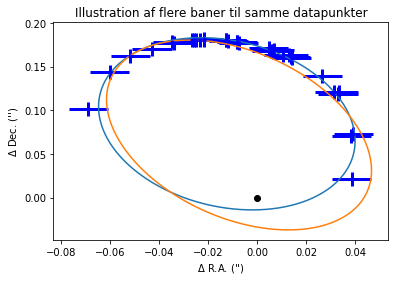

In [391]:
plt.errorbar(data_S2[1], data_S2[2], xerr=0.008, yerr=0.008, fmt='.', color='blue', elinewidth=3)
t = np.linspace(0,2*np.pi, 1080)
X1, Y1 = f(t, 0.1, 0.86, 2.01, 3.73, 3.01)
plt.plot(X1,Y1)
X2, Y2 = f(t, 0.115, 0.67, 0.44, 1.93, 2.16)
plt.plot(X2,Y2)
plt.plot(0,0,'o',c='black')
plt.xlabel("$\Delta$ R.A. ('""')")
plt.ylabel("$\Delta$ Dec. ('""')")
plt.title("Illustration af flere baner til samme datapunkter")

In [173]:
%matplotlib inline

In [621]:
a_S62_new = [0.0775,
 0.08607142857142858,
 0.08607142857142858,
 0.08607142857142858,
 0.08607142857142858,
 0.08607142857142858,
 0.08607142857142858,
 0.08607142857142858,
 0.09464285714285714,
 0.18035714285714288,
 0.1975,
 0.1975,
 0.1975]

e_S62_new = [0.9814042385603234,
 0.9155555555555555,
 0.9843851790211351,
 0.9843836577824079,
 0.98437989311923,
 0.97,
 0.97,
 0.9843839931025062,
 0.883410846576305,
 0.861111111111111,
 0.8466666666666667,
 0.9011111111111111,
 0.9011111111111111]

omega_S62_new = [3.0765810864122867,
 6.283185307179586,
 2.5620982176233533,
 3.783966281749352,
 3.085719557550748,
 3.077853428618304,
 3.205325250722489,
 3.9781186982281467,
 3.213464167344717,
 2.972862605677417,
 4.261924858837331,
 4.4182353175641955,
 1.8779325726128393]

OMEGA_S62_new = [5.301999312281245,
 2.2186654934724097,
 4.769284719505024,
 4.706388248673837,
 5.29286084306415,
 5.357253996208581,
 5.356947191723198,
 6.185292449547692,
 5.34388972105316,
 5.4132025077275046,
 5.331740280659769,
 5.328845512253885,
 5.329592661225455]

inc_S62_new = [3.141592653589793,
 5.145282743342261,
 3.141592653589793,
 6.283185307179586,
 3.141592653589793,
 4.148425877516301,
 5.277762104325047,
 3.141592653589793,
 5.012171088571406,
 4.6538331546101475,
 5.267169956244571,
 4.759008971255934,
 4.665716888745073]

In [554]:
index = 0
mini_min = 10

for i in range(len(a_S62_new)):
    mini = finding_areas(data_S62, a_S62_new[i], e_S62_new[i], omega_S62_new[i], OMEGA_S62_new[i], inc_S62_new[i])[0]
    
    if mini < mini_min and mini > 1.2795*10**-9:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S62, a_S62_new[index], e_S62_new[index], omega_S62_new[index], OMEGA_S62_new[index], inc_S62_new[index]))
print(a_S62_new[index], e_S62_new[index], np.degrees(omega_S62_new[index]), np.degrees(OMEGA_S62_new[index]), np.degrees(inc_S62_new[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S62_new)):
    mini = finding_areas(data_S62, a_S62_new[i], e_S62_new[i], omega_S62_new[i], OMEGA_S62_new[i], inc_S62_new[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S62_new[i]) 
        e_delta.append(e_S62_new[i])
        omega_delta.append(omega_S62_new[i]) 
        OMEGA_delta.append(OMEGA_S62_new[i])
        inc_delta.append(inc_S62_new[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

6 3.9278166969588514e-09
(3.9278166969588514e-09, 10.381992764242401, 0.0020908787657236134)
0.08607142857142858 0.97 183.65160883311106 306.9304651601979 302.3934938519093


a: 0.08607142857142858 - 0.08607142857142858
e: 0.97 - 0.9843836577824079
omega: 3.205325250722489 - 3.783966281749352
OMEGA: 4.706388248673837 - 5.356947191723198
inc: 5.277762104325047 - 6.283185307179586


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


In [282]:
a =  0.08607142857142858 
P = 8.384977999167694
D = 8.175

a = np.tan(np.radians(a/60**2))*D*3.08577*10**19
P = P*365*24*60**2

G = 6.67*10**-11

M = (4*np.pi**2*a**3)/(G*P**2)
M = M/(1.989*10**30 * 10**6)
print(M)

4.964066909299408


In [288]:
100/24 * 678 / 60

47.083333333333336

In [622]:
a_S2_new = [0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571388736,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10821428571428572,
 0.10568647704438557,
 0.10819237083661633,
 0.10633947693707728,
 0.10633762631084226,
 0.10642223999886563,
 0.10589713261962619,
 0.10633947485135908,
 0.10633724073905065,
 0.10589712286516581,
 0.10642911154731874,
 0.10779178467103603,
 0.11252708328524767,
 0.1125808588275694,
 0.11259614899532684,
 0.11186687130882796,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.11527242943789551,
 0.1117857142857143,
 0.1117857142857143,
 0.11470081524795593,
 0.11649555770071321,
 0.1117857142857143,
 0.12035714285714286,
 0.12075715430067631,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12072514445428655,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.14086071721072096,
 0.14095071564290462,
 0.14086072834195484,
 0.14095071575317406]

e_S2_new = [0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7922222222222222,
 0.7865516090794054,
 0.7875056614073499,
 0.7880459192672439,
 0.7922222222222222,
 0.773834118236017,
 0.7922222222222222,
 0.7922222222222222,
 0.8066666666666666,
 0.8066666666666666,
 0.8066675308547312,
 0.8298944359706307,
 0.8066666666666666,
 0.8066666666666666,
 0.8298944646679401,
 0.8066666666666666,
 0.861111111111111,
 0.6788032327711417,
 0.6833333333333333,
 0.6833333333333333,
 0.7030637045565351,
 0.7921787787845195,
 0.7922038451254768,
 0.7780993771010788,
 0.7921967268835527,
 0.8459786756700269,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8273986539368459,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8239882046449185,
 0.8278265147185836,
 0.8079436176930558,
 0.8070294009467487,
 0.8355884502490929,
 0.8066666666666666,
 0.8066666666666666,
 0.861111111111111,
 0.861111111111111,
 0.861111111111111,
 0.861111111111111,
 0.8652723229365099,
 0.8638996307876129,
 0.8689329649797414,
 0.861111111111111,
 0.865158707191381,
 0.8638997148209168,
 0.8681882035524516,
 0.8632596757336182,
 0.9155555555555555,
 0.9155555555555555,
 0.9155555555555555,
 0.9155555555555555]

omega_S2_new = [0.38370005694123743,
 0.37834048757051825,
 3.5194220637933276,
 3.518351558416595,
 3.517716382562946,
 3.520082332148714,
 2.7643074067171383,
 3.525291825849975,
 2.7608366910083246,
 2.7609850810237324,
 5.905647186275783,
 0.38296168086196797,
 2.764655253709411,
 0.6058041440934808,
 2.57611452781877,
 2.5736973687305538,
 3.7130414337377347,
 3.747394454646385,
 3.6555893453126505,
 2.6668628025187915,
 5.694391977984311,
 2.56371375294837,
 2.5621573580645176,
 0.5831954637471113,
 2.420273382046715,
 5.705306426976751,
 5.703755092789548,
 5.561866231150778,
 3.7248185499278295,
 1.1031110864537097,
 0.38131964282997577,
 3.542539461424061,
 5.881606694372087,
 5.850656307493758,
 0.6985246852078221,
 2.443844740054767,
 2.486810652512735,
 5.58492470351905,
 0.9354796288927663,
 0.7446399509097565,
 0.7479633632521882,
 2.3945510855542946,
 2.395589522872469,
 2.399173415262224,
 0.7515521636552557,
 0.7467348070238431,
 2.395344540632642,
 2.3099000566091092,
 2.3950389603132223,
 2.394896293717649,
 3.8862955959268284,
 5.5360095516457735,
 5.537182109245454,
 5.540765695714477,
 3.960840747543659,
 3.9744198927794403,
 5.530348783636342,
 5.531129015891734,
 5.370075052533483,
 3.8894648337605147,
 3.888327433470966,
 1.055818983542325,
 2.125691059046605,
 2.1153746616552236,
 1.0564274802904812,
 1.0785580598757274,
 1.0771109308120606,
 2.0330929784436025,
 4.198016089025847,
 4.219651552102349,
 4.218704184907684,
 5.180819481804585,
 5.203812035788962,
 1.8144449189877672,
 1.3260494197302186,
 4.956037494638291,
 4.467642064351266]

OMEGA_S2_new = [1.464821158998002,
 1.4684656443588848,
 4.610713961925532,
 4.611474228861515,
 4.611878946411923,
 4.6102471127990965,
 4.611095974436474,
 4.606414337127469,
 4.608215864775977,
 4.609000129730557,
 1.4687641626917505,
 1.4662279134611906,
 4.610835697071248,
 1.2598255271106722,
 4.440338147759965,
 4.437513050839639,
 4.433859685137864,
 4.401420134607428,
 4.491012881716146,
 4.4912414066342325,
 1.2728220552351759,
 4.396654195945512,
 4.394992355706316,
 1.2505762575118822,
 4.234913309668433,
 1.2550615247140624,
 1.2534005706339857,
 1.0933207125078537,
 4.3921644162724425,
 0.6781127265856578,
 1.5071903642424587,
 4.636575819998922,
 1.49355368961608,
 1.4645989629765792,
 1.2093488224899114,
 4.351416674382819,
 4.400228893665423,
 1.2095347178370768,
 0.9177151967287404,
 1.1547916736554724,
 1.1508940156341294,
 4.293443646235461,
 4.294712885208658,
 4.297788156338002,
 1.14659662550219,
 1.151669290121979,
 4.293798989066048,
 4.189527146001384,
 4.293806642973501,
 4.293662635146139,
 4.296215129860457,
 1.151742705009664,
 1.153120157782107,
 1.156195120141198,
 4.204956043945226,
 4.187839452518906,
 1.14449735361505,
 1.1458747641010552,
 0.9901076185774096,
 4.292399649008823,
 4.29326196916766,
 0.7942740672243915,
 4.001569945466536,
 3.94268751792293,
 0.8453957304672602,
 0.8179915254250884,
 0.8172437776561511,
 3.913781322801743,
 3.9869934975378465,
 3.9600908690656667,
 3.958835585588756,
 0.7807569742436234,
 0.8141271450635883,
 3.6872814005974344,
 0.5478475363373992,
 0.5456886864451415,
 3.6894402065625047]

inc_S2_new = [0.7663798106119739,
 5.515621312382722,
 5.515018127182632,
 0.7684128166425878,
 5.515463303945458,
 0.7680609208247359,
 3.910103774177366,
 0.7663794188603238,
 2.376338158963135,
 3.9087583626774105,
 2.37477734271671,
 5.516810951792711,
 3.9072610998910338,
 0.6855192223319541,
 2.4393299072706496,
 3.8403004995704704,
 5.584483852008831,
 0.6855202213592094,
 0.720742832788928,
 3.7836751760951537,
 3.827217040400922,
 2.520858325547407,
 3.762893010338059,
 5.661173923319001,
 3.6841200097634563,
 2.520858387321539,
 3.7628811072651054,
 3.6841196953509323,
 5.661106315783568,
 5.800733147552403,
 0.8731052823868697,
 5.415976282364669,
 2.27359588489344,
 2.2967264996364936,
 5.541281475601172,
 3.8820897063419775,
 2.3775211169543264,
 2.4004363215330833,
 5.651479518312408,
 5.56357094416135,
 0.7183236687178917,
 3.858276211997744,
 2.4227234036104695,
 3.8590437811484337,
 0.715014360174462,
 5.5667638269156665,
 2.425871689686269,
 2.4651272535674855,
 2.4247887693017085,
 3.8585493563574156,
 5.564629233890082,
 3.8583099797657563,
 2.4227234627482006,
 3.8590438755464516,
 0.682690756602907,
 5.607781262259174,
 3.8547668941160564,
 2.4278802966591666,
 2.4178940580232497,
 0.7176458767067999,
 5.56676383357682,
 0.6471880886778366,
 2.440587019645559,
 3.7402561770796883,
 0.7473763308290066,
 0.746670809784991,
 5.5442250876225785,
 3.8673642605109357,
 0.7473773699514437,
 0.7465085893771736,
 5.544225329996955,
 3.870352064965173,
 2.404181205626988,
 4.01078282124176,
 0.8701524121336871,
 4.010782872537178,
 0.8701524106519817]

In [485]:
index = 0
mini_min = 10

for i in range(len(a_S2_new)):
    mini = finding_areas(data_S2, a_S2_new[i], e_S2_new[i], omega_S2_new[i], OMEGA_S2_new[i], inc_S2_new[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S2, a_S2_new[index], e_S2_new[index], omega_S2_new[index], OMEGA_S2_new[index], inc_S2_new[index]))
print(a_S2_new[index], e_S2_new[index], np.degrees(omega_S2_new[index]), np.degrees(OMEGA_S2_new[index]), np.degrees(inc_S2_new[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S2_new)):
    mini = finding_areas(data_S2, a_S2_new[i], e_S2_new[i], omega_S2_new[i], OMEGA_S2_new[i], inc_S2_new[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S2_new[i]) 
        e_delta.append(e_S2_new[i])
        omega_delta.append(omega_S2_new[i]) 
        OMEGA_delta.append(OMEGA_S2_new[i])
        inc_delta.append(inc_S2_new[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

8 1.2964509416079241e-08
(1.2964509416079241e-08, 0.07164780464603951, 16.47342410913028)
0.1117857142857143 0.8278265147185836 227.7174858690991 239.94552590771065 321.3021987599961


a: 0.10642911154731874 - 0.12035714285714286
e: 0.8066666666666666 - 0.8638997148209168
omega: 3.7248185499278295 - 4.218704184907684
OMEGA: 3.958835585588756 - 4.3921644162724425
inc: 5.538761129635572 - 5.661106315783568


In [327]:
a_S38_new = [0.14246542823244773,
 0.14607142857142857,
 0.14853526333939104,
 0.15104794049385048,
 0.15644408779194816,
 0.15464285714285714,
 0.15464285714285714,
 0.15464285714285714,
 0.15531359069897296,
 0.15522875152394924,
 0.1682142857142857,
 0.16542651706433292,
 0.1682142857142857,
 0.16402921862671102,
 0.16666859041414167,
 0.1677285956872583,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1717857142857143,
 0.1730454599080152,
 0.1753713959208058,
 0.17583715012492396,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1720224290341499,
 0.1717857142857143,
 0.1720058614751411,
 0.1717857142857143,
 0.1739227780962188,
 0.18035714285714288,
 0.18035714285714288,
 0.18512493104635805,
 0.18035714285714288,
 0.1804360116601609,
 0.18035714285714288,
 0.18149243929208608,
 0.18035714285714288,
 0.18106298821263944,
 0.18035714285714288,
 0.18035714285714288,
 0.1889607676599677,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18924833962802423,
 0.18892857142857145,
 0.18892857142857145,
 0.18997207318829057,
 0.189073320792974,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.19941808988985446,
 0.1975,
 0.1975]

e_S38_new = [0.8442826177173894,
 0.7922222222222222,
 0.7888231976459573,
 0.84510420558748,
 0.7377777777777778,
 0.7558425184608348,
 0.7922222222222222,
 0.7922222222222222,
 0.8615884754826899,
 0.8611391642669024,
 0.6288888888888889,
 0.6833333333333333,
 0.6833333333333333,
 0.7018058041803283,
 0.7377777777777778,
 0.7115940091210621,
 0.7220021411192116,
 0.7794346829106906,
 0.7921376069117049,
 0.7522222222222221,
 0.5744444444444444,
 0.6288888888888889,
 0.598963719584848,
 0.6832878005584473,
 0.7377777777777778,
 0.7377777777777778,
 0.7922058315446723,
 0.7922222222222222,
 0.7922045910453485,
 0.7522222222222221,
 0.8066666666666666,
 0.8066666666666666,
 0.8622725023224395,
 0.6678576575919513,
 0.6498412797383696,
 0.6833333333333333,
 0.683316428406302,
 0.7237582557446683,
 0.6977777777777777,
 0.7522222222222221,
 0.7667159081567678,
 0.861111111111111,
 0.8800004562181317,
 0.8612376855022607,
 0.7271892380196161,
 0.7377766974326468,
 0.7349516715637168,
 0.732155827128788,
 0.7302558481429747,
 0.726804875063877,
 0.7295207679218316,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.9155555555555555,
 0.9168399494423142,
 0.7530675789943969,
 0.773615642588087,
 0.7524155347619597,
 0.7836757318390387,
 0.7736303250483918,
 0.7522222222222221,
 0.9166940439192254]

omega_S38_new = [4.479376204535007,
 3.6758480036102905,
 5.646770780790084,
 4.213780657958678,
 2.4911352576330077,
 2.4825102304065316,
 5.4989337069033635,
 3.9225354911126393,
 1.8504875074324456,
 4.9882721771441645,
 2.5146499845967436,
 2.452875876433123,
 5.535591820043837,
 2.439489381254227,
 3.9559456264804753,
 5.504700920740012,
 3.868366798252633,
 2.272965186868598,
 5.379674992964528,
 5.492473470724999,
 3.728557384390782,
 2.4241991612684384,
 5.582244369556158,
 5.44328193234179,
 5.406448373943665,
 4.016124975552485,
 2.1558063829861616,
 5.296526755796662,
 4.128768881098522,
 5.380907066978107,
 4.161399825518693,
 4.162148531710717,
 5.039189381280571,
 2.273214756576875,
 5.441097047387147,
 4.035881369928596,
 4.034562285292133,
 5.337623939461818,
 5.374958935365969,
 4.132364311651114,
 4.154927553094833,
 4.344793002391556,
 4.971544191310337,
 5.053655259198412,
 2.113726632907234,
 2.1104739848336918,
 5.25551291919757,
 4.166844204406049,
 4.165103166024574,
 4.165187363493768,
 4.163877604365563,
 2.092217082972102,
 2.1090758569765162,
 5.234393981856871,
 4.192105890673199,
 1.5933684433399025,
 4.720290674875527,
 2.0357852643817593,
 4.2683359006600625,
 5.177961236103536,
 4.275200180437094,
 5.163984612695695,
 4.250740122888576,
 1.628053131683576]

OMEGA_S38_new = [5.060193983270737,
 5.944491374319397,
 2.7322197975444715,
 5.394610058138083,
 5.951359028178462,
 5.920047245001144,
 2.634570154980229,
 5.778964125898048,
 5.155912732431042,
 2.009760903294779,
 6.085502745848463,
 6.005438849249896,
 2.8368346380376797,
 5.976641446500361,
 5.876772426042807,
 2.7905634392124874,
 5.9396091033170295,
 5.767345599246729,
 2.578653691770978,
 2.7224658349283173,
 6.142323023141458,
 6.05244278305509,
 2.9440433308949996,
 2.8079313240571415,
 2.7124467064707622,
 5.855059525626333,
 5.693740014661927,
 2.551544636776491,
 5.694123749247668,
 2.676639403370434,
 5.642510575091872,
 5.639741020919997,
 2.1674001697685745,
 5.95838194234071,
 2.834948886531967,
 5.941763126986245,
 5.933426833003331,
 2.716743281247182,
 2.7682955812223766,
 5.795018030093248,
 5.746908896712797,
 5.405649443649904,
 2.084152583653614,
 2.2244448912514434,
 5.82900989251793,
 5.814278730028327,
 2.679257327927143,
 5.826137359111685,
 5.830284517046617,
 5.8325963713040005,
 5.830934292732876,
 5.781135815661209,
 5.8067846362254265,
 2.640269659362546,
 5.77969284892282,
 4.853237845182807,
 4.802148864845025,
 5.770159859555427,
 5.724234240455108,
 2.630009508032571,
 5.703524623079313,
 2.607022712831672,
 5.768506573618878,
 4.922544799584221]

inc_S38_new = [5.989895025173658,
 5.714206276881058,
 3.7345401119362824,
 5.767161556280839,
 2.3878244703521605,
 2.4310893582800546,
 3.801608150821515,
 5.623007289784411,
 2.604228123767134,
 3.6770678378430186,
 2.2307666904323398,
 2.289833234150263,
 4.014214943643716,
 2.3042677917614727,
 5.458773700224287,
 3.9865178850337433,
 5.476281218534845,
 3.8932778123510645,
 3.880262969395045,
 3.9290468048219154,
 5.3378345842252735,
 4.068103591616747,
 4.095972271103706,
 4.0457217803421885,
 3.993037494339361,
 5.427714881059843,
 3.945084568450099,
 3.9454170740765195,
 5.476086786949031,
 3.9819362156214773,
 5.489826003025898,
 5.492569019881692,
 3.8785354158188006,
 2.2201752142341262,
 4.06971631975467,
 5.370435498034244,
 5.354529028271977,
 4.049569046390511,
 4.061883536028795,
 5.38669725399964,
 5.42191986990136,
 5.4743026059247475,
 3.913775578778203,
 3.9321907186403937,
 2.2057303003448254,
 4.073022317422968,
 4.074831923279372,
 5.348100415258691,
 5.343416549231206,
 5.3486368753240505,
 5.350564915103669,
 2.218995432549926,
 2.1782883665642574,
 4.064652093986546,
 5.362721392950392,
 2.3349230777223897,
 5.48065459633287,
 2.1940201971515525,
 5.3390110254870615,
 4.086366387739275,
 5.344178033085406,
 4.122750843832123,
 5.337205901161586,
 3.9862111021325757]

In [486]:
index = 0
mini_min = 10

for i in range(len(a_S38_new)):
    mini = finding_areas(data_S38, a_S38_new[i], e_S38_new[i], omega_S38_new[i], OMEGA_S38_new[i], inc_S38_new[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S38, a_S38_new[index], e_S38_new[index], omega_S38_new[index], OMEGA_S38_new[index], inc_S38_new[index]))
print(a_S38_new[index], e_S38_new[index], np.degrees(omega_S38_new[index]), np.degrees(OMEGA_S38_new[index]), np.degrees(inc_S38_new[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S38_new)):
    mini = finding_areas(data_S38, a_S38_new[i], e_S38_new[i], omega_S38_new[i], OMEGA_S38_new[i], inc_S38_new[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S38_new[i]) 
        e_delta.append(e_S38_new[i])
        omega_delta.append(omega_S38_new[i]) 
        OMEGA_delta.append(OMEGA_S38_new[i])
        inc_delta.append(inc_S38_new[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

2 8.059417313064785e-08
(8.059417313064785e-08, 0.09121911446705681, 17.04345581940392)
0.14246542873151075 0.844282638305764 76.64934957076983 109.92775966913631 343.19570060102984


a: 0.14245963257484917 - 0.18199596130297346
e: 0.791060741570151 - 0.898133420206983
omega: 0.5321233416491458 - 4.638906035273573
OMEGA: 1.9186013455674609 - 5.944491374319397
inc: 0.29347298813176803 - 5.989895025173658


In [334]:
a_S55_new = [0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.12035714285714286,
 0.1375,
 0.1375,
 0.14607142857142857,
 0.14607142857142857,
 0.1717857142857143]

e_S55_new = [0.6440444022351521,
 0.6566962612284177,
 0.6572735799389988,
 0.6602617965616031,
 0.7206870315985776,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222]

omega_S55_new = [5.020611784582139,
 4.497728027196054,
 5.5454255898746565,
 4.497721232825559,
 4.745404638663667,
 1.7627898728150058,
 4.497721065613963,
 5.545424510935218,
 5.093089170535278]

OMEGA_S55_new = [3.356540055181754,
 2.8336548178941885,
 3.881352344763146,
 2.8336616099762795,
 3.076112989832076,
 2.898645253028544,
 2.833661811288316,
 3.881353420843554,
 3.285491425767062]

inc_S55_new = [3.141592653589793,
 3.141592653589793,
 3.141592653589793,
 3.141592653589793,
 3.7116824852986694,
 0.682869698363062,
 3.141592653589793,
 3.141592653589793,
 3.141592653589793]

In [488]:
index = 0
mini_min = 10

for i in range(len(a_S55_new)):
    mini = finding_areas(data_S55, a_S55_new[i], e_S55_new[i], omega_S55_new[i], OMEGA_S55_new[i], inc_S55_new[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S55, a_S55_new[index], e_S55_new[index], omega_S55_new[index], OMEGA_S55_new[index], inc_S55_new[index]))
print(a_S55_new[index], e_S55_new[index], np.degrees(omega_S55_new[index]), np.degrees(OMEGA_S55_new[index]), np.degrees(inc_S55_new[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S55_new)):
    mini = finding_areas(data_S55, a_S55_new[i], e_S55_new[i], omega_S55_new[i], OMEGA_S55_new[i], inc_S55_new[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S55_new[i]) 
        e_delta.append(e_S55_new[i])
        omega_delta.append(omega_S55_new[i]) 
        OMEGA_delta.append(OMEGA_S55_new[i])
        inc_delta.append(inc_S55_new[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

32 6.389950224401537e-08
(6.389950224401537e-08, 0.1354375271677718, 25.858231855834457)
0.1375 0.7377777777777778 231.05191719447072 129.06257166496553 180.5865194216185


a: 0.12892857142857145 - 0.1717857142857143
e: 0.6833333333333333 - 0.7922222222222222
omega: 0.0034995722025370638 - 5.40881553294354
OMEGA: 0.0 - 4.506656647101131
inc: 3.091176644833057 - 3.305677396613065


In [383]:
a = 0.11782799661299123 
P = 15.906586858044442
e = 0.8714285714285714
D = 8.14

a = 0.08607142857142858 
P = 8.384977999167694
e = 0.9843
D = 8.175

P = P*365*24*60**2
a = np.tan(np.radians(a/60**2))*D*3.08577*10**19

pp = 24*np.pi**3*a**2/(P**2 * (3*10**8)**2 * (1-e**2))
print(np.degrees(pp))
print(pp)

2.4098350294909747
0.04205955569451216


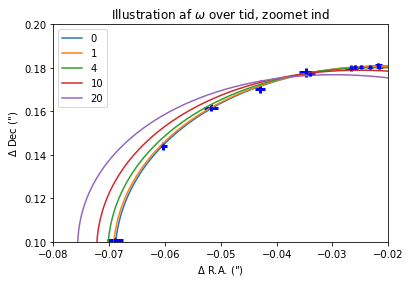

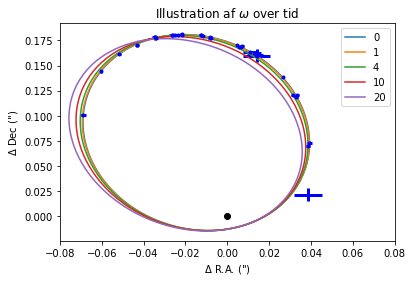

In [395]:
t = np.linspace(0,2*np.pi,720)

for i in [0,1,4, 10,20]:
#for i in [0,10,20,30,40]:
#for i in [0,50,100,150,200,250]:
    X,Y = f(t,0.11782799661299123, 0.8714285714285714, np.radians(63.391786160960734) + 0.0028*i, np.radians(43.06501830780104), np.radians(39.44226305180918))
    plt.plot(X,Y)
    
xerr = np.array(data_S2[3])
yerr = np.array(data_S2[4])
plt.errorbar(data_S2[1], data_S2[2], xerr=xerr, yerr=yerr, fmt='.', color='blue', elinewidth=3)
plt.plot(0,0,'o',c='black')
plt.legend(["0","1","4","10","20"])
plt.xlabel('$\Delta$ R.A. (")') 
plt.ylabel('$\Delta$ Dec (")') 
plt.title("Illustration af $\omega$ over tid, zoomet ind")
plt.xlim([-0.08, -0.02])
plt.ylim([0.1,0.2])


plt.figure()
for i in [0,1,4, 10,20]:
#for i in [0,10,20,30,40]:
#for i in [0,50,100,150,200,250]:
    X,Y = f(t,0.11782799661299123, 0.8714285714285714, np.radians(63.391786160960734) + 0.0028*i, np.radians(43.06501830780104), np.radians(39.44226305180918))
    plt.plot(X,Y)
    
xerr = np.array(data_S2[3])
yerr = np.array(data_S2[4])
plt.errorbar(data_S2[1], data_S2[2], xerr=xerr, yerr=yerr, fmt='.', color='blue', elinewidth=3)
plt.plot(0,0,'o',c='black')
plt.title("Illustration af $\omega$ over tid")
plt.xlabel('$\Delta$ R.A. (")') 
plt.ylabel('$\Delta$ Dec (")') 
plt.xlim([-0.08, 0.08])
plt.legend(["0","1","4","10","20"])

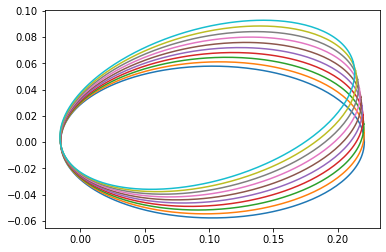

In [347]:
t = np.linspace(0,2*np.pi,720)

for i in np.linspace(0,100,10):
    X,Y = f(t,0.11782799661299123, 0.8714285714285714, 0 + 0.0028*i, 0, 0)
    plt.plot(X,Y)

0.7504915783575618

In [396]:
16*4

64

In [401]:
np.tan( np.radians(0.08607142857142858 *  (1-0.9843836577824079)/60**2 )) * 8.175

5.327223981834701e-08

In [456]:
a = 0.08607142857142858 *  (1-0.9843836577824079) 
e = 0.9843
D = 8.175

a = np.tan(np.radians(a/60**2))*D*3.08577*10**19
a_pc = 0.08607142857142858 *  (1-0.9843836577824079)
a_pc = np.tan(np.radians(a_pc/60**2))*D*10**3
print(a)

1643858794642.6064


In [451]:
M = 4.61*10**6 * 1.989*10**30
rs = 2*6.67*10**-11 * M/ (3*10**8)**2
print(rs)

13590925400.000002


In [457]:
V = 4/3 * np.pi * a**3
M = 4.61*10**6 * 1.989*10**30

M_M_sol = 4.61*10**6
V_pc = 4/3 * np.pi * a_pc**3

dens = M/V
dens_sol_pc = M_M_sol/V_pc

print(dens)
print(dens_sol_pc)

0.49278056460581066
7.279632331103715e+18


In [560]:
a_S38_new = [0.14250000000000002,
 0.14245963310723236,
 0.14246542873151075,
 0.14245963257484917,
 0.14246542823244773,
 0.14607142857142857,
 0.14789474427612648,
 0.14789414438876683,
 0.14654493736130825,
 0.14607142857142857,
 0.14626193399172466,
 0.15104805363340817,
 0.15104794085124595,
 0.14907821142195904,
 0.14922751199979326,
 0.14757159274851994,
 0.1465271615723654,
 0.14757178317960506,
 0.1510480540800378,
 0.15104794049385048,
 0.14908298224658237,
 0.15029485624022354,
 0.15961678760916234,
 0.15962923253876546,
 0.15964285714285714,
 0.1596285726179002,
 0.15964285714285714,
 0.15964285714285714,
 0.1585753558490317,
 0.1572799585608487,
 0.15531454139779285,
 0.15724337947920702,
 0.15638602833135687,
 0.1550549833154768,
 0.15464285714285714,
 0.15464285714285714,
 0.15964285714285714,
 0.15474095386581302,
 0.15464285714285714,
 0.15464285714285714,
 0.15464285714285714,
 0.15500395618919888,
 0.15487154675552434,
 0.15535071426888936,
 0.1590228155098445,
 0.15480410889491036,
 0.15902320246378168,
 0.15530640405504875,
 0.1632142857142857,
 0.1682142857142857,
 0.1682142857142857,
 0.1682142857142857,
 0.1682142857142857,
 0.16805183977487975,
 0.16562007038948892,
 0.1682142857142857,
 0.16400713539224912,
 0.16595354007760618,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.16691931113092248,
 0.1640785916696134,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.16818334756919986,
 0.16326498347792048,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.16466033057620164,
 0.16323277546876833,
 0.1632142857142857,
 0.1632142857142857,
 0.16666859041414167,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.16763853240255197,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.16391668623545316,
 0.16367234480595425,
 0.1632142857142857,
 0.1632142857142857,
 0.163217071294475,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.16393709811848078,
 0.1632142857142857,
 0.16738792493830396,
 0.16821356940617138,
 0.17678537198884492,
 0.1736010115777186,
 0.1717857142857143,
 0.1767857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17228357405111586,
 0.17272775925638173,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.173829723657802,
 0.17308982310213708,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17308507507323165,
 0.1727626355590253,
 0.1717857142857143,
 0.17547890617632544,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17180880516150956,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17218419901908602,
 0.17190156306983878,
 0.1722851015474951,
 0.1734651514021914,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17598013815548105,
 0.1720223476091947,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1720224290341499,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17651858739074694,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17212572168677762,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.17596638848377683,
 0.17191124469102864,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.1767857142857143,
 0.17659444032880933,
 0.17181225588387783,
 0.17652818092992725,
 0.1765184787140861,
 0.17659444146350078,
 0.17652818124830752,
 0.17198689357989835,
 0.17199965596118963,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18512530772187144,
 0.18035714285714288,
 0.18039311985452317,
 0.18089881572641917,
 0.18512493104635805,
 0.18035714285714288,
 0.18264997191822488,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18149243929208608,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288,
 0.18047721317478507,
 0.18035714285714288,
 0.18178164146174938,
 0.18035714285714288,
 0.18049963462654708,
 0.18035714285714288,
 0.18035714285714288,
 0.18199596130297346,
 0.18035714285714288,
 0.18153378451870306,
 0.18049964130013682,
 0.18035714285714288,
 0.18035714285714288,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18893365277106786,
 0.18892857142857145,
 0.18892857142857145,
 0.1891638740272539,
 0.19090262114797893,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.188989053692601,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18903883355758203,
 0.18904528957997987,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.1889475356073543,
 0.18924253805235183,
 0.1896045521640965,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.1889476162541932,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18892857142857145,
 0.18946915921471597,
 0.19297535646754863,
 0.18967524341807748,
 0.18892857142857145,
 0.19304533334732601,
 0.1928882915750041,
 0.18968700749841166,
 0.18962314868457017,
 0.19129610441491876,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.19766616656915542,
 0.197757335374938,
 0.19757144015122116,
 0.19794549893987323,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.19779798218591313,
 0.1975,
 0.19919215168308183,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.1975,
 0.20128985261850443,
 0.201683495615519,
 0.19794584961293923,
 0.1975,
 0.20165605900249417,
 0.1975,
 0.1975,
 0.2017094004869687,
 0.1975,
 0.2024964306349462,
 0.20228630158894687,
 0.1975,
 0.20249644515408444,
 0.20215326580840431,
 0.19828637076163286,
 0.198748508608981,
 0.19828646500016672]

e_S38_new = [0.8305757472192713,
 0.8442389966198267,
 0.844282638305764,
 0.8442389893217817,
 0.8442826177173894,
 0.7922222222222222,
 0.7910699504824382,
 0.791060741570151,
 0.7922222222222222,
 0.7922222222222222,
 0.8322205862414404,
 0.8450964600927781,
 0.8451042032834242,
 0.8066666666666666,
 0.8068034141986119,
 0.8466666666666667,
 0.8466666666666667,
 0.8466666666666667,
 0.8450964595811261,
 0.84510420558748,
 0.8068524582795787,
 0.861111111111111,
 0.6288888888888889,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.7061715825915066,
 0.7228407416757815,
 0.705255119456217,
 0.7377777777777778,
 0.7377777777777778,
 0.7372061293025448,
 0.7067548099866724,
 0.7638612436117123,
 0.75725459966514,
 0.7569928454262247,
 0.7922222222222222,
 0.809474706932423,
 0.8095510479900062,
 0.8066667025594851,
 0.8611733146314189,
 0.8611115075551027,
 0.873328534261643,
 0.862218565723268,
 0.8733288508764983,
 0.8611340101649865,
 0.5888888888888889,
 0.6288888888888889,
 0.6256738685593566,
 0.6288888888888889,
 0.6288888888888889,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6575162968923431,
 0.703805056530271,
 0.7377777777777778,
 0.7161092512285304,
 0.7270245239314839,
 0.7375373004558403,
 0.7377777777777778,
 0.7197725714958926,
 0.7377777777777778,
 0.7377777777777778,
 0.7319947279320574,
 0.6978034655508013,
 0.7377777777777778,
 0.6977777777777777,
 0.6977777777777777,
 0.7069699338047825,
 0.7375363677359048,
 0.7209719521770506,
 0.7377777777777778,
 0.6977777777777777,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7122717034741217,
 0.7377777777777778,
 0.7220021411192116,
 0.7922222222222222,
 0.7922167620274777,
 0.7920320395768669,
 0.7522487048505399,
 0.7523094814950382,
 0.7922162149409087,
 0.7919782643377762,
 0.7543625912159878,
 0.7922222222222222,
 0.7921163315148477,
 0.7921826712280186,
 0.7916779476899066,
 0.7920695504050276,
 0.7920318113303757,
 0.7922222222222222,
 0.792116323669645,
 0.7522998891495034,
 0.7917891471259775,
 0.8698193219238977,
 0.8611122480963287,
 0.5744444444444444,
 0.6168713013768232,
 0.6288888888888889,
 0.6833333333333333,
 0.6808906565644873,
 0.6433333333333333,
 0.6755311386925535,
 0.6831571826266765,
 0.6833333333333333,
 0.6833333333333333,
 0.678918971745554,
 0.6833333333333333,
 0.6832740876055702,
 0.6832740973913161,
 0.6827165560724984,
 0.6833333333333333,
 0.6790516109113571,
 0.6826692491687008,
 0.6833333333333333,
 0.7377777777777778,
 0.7377500071640917,
 0.7377747526592304,
 0.736588325951887,
 0.7377573132652324,
 0.7130907360851029,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.6977777777777777,
 0.6977777777777777,
 0.7377573370917797,
 0.7377777777777778,
 0.7375985879583508,
 0.7377777777777778,
 0.7365883599558722,
 0.73774360216736,
 0.7377777777777778,
 0.7377533556374224,
 0.7369791403287987,
 0.7377777777777778,
 0.7522222222222221,
 0.7865060902991204,
 0.7522222222222221,
 0.7922046165798424,
 0.7522222222222221,
 0.7846030863676614,
 0.7751019386465802,
 0.7769214152931773,
 0.7922192668787025,
 0.7922142766968276,
 0.7922045910453485,
 0.7522222222222221,
 0.7522222222222221,
 0.7921311836142972,
 0.8093247008035127,
 0.8080123564745344,
 0.8066666666666666,
 0.80672698664319,
 0.8066666666666666,
 0.8466666666666667,
 0.8466666666666667,
 0.8466666666666667,
 0.8466647951094692,
 0.8066666666666666,
 0.8084540992511803,
 0.8463020740415849,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.8066666666666666,
 0.861111111111111,
 0.8655700844713965,
 0.8611244167740004,
 0.8653347894029154,
 0.898133420206983,
 0.8655700869930975,
 0.8653347897724657,
 0.8611125793442451,
 0.861179243847397,
 0.5889718105390326,
 0.6833333333333333,
 0.6820572230029395,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833054850645338,
 0.6833333333333333,
 0.683316428406302,
 0.6977777777777777,
 0.7362608053451759,
 0.7339296041932444,
 0.7353543801514609,
 0.6977777777777777,
 0.7353762484902676,
 0.7372827662221492,
 0.6977777777777777,
 0.7362607897587884,
 0.7604613902990532,
 0.7729538102922765,
 0.7917195213387465,
 0.7539662987934374,
 0.7522222222222221,
 0.7697964277115534,
 0.7715170007695358,
 0.7667159081567678,
 0.8447994262085429,
 0.8466666666666667,
 0.8466663262379794,
 0.844808224220187,
 0.8466666666666667,
 0.8066666666666666,
 0.8466663325958441,
 0.861111111111111,
 0.8631926339124897,
 0.861111111111111,
 0.8611615581251609,
 0.861111111111111,
 0.8810805275041024,
 0.8913507132506763,
 0.8613543830356895,
 0.861111111111111,
 0.8611427111306951,
 0.861111111111111,
 0.6833333333333333,
 0.6832209262078396,
 0.6833333333333333,
 0.7260443637842041,
 0.7252253355682052,
 0.7290808982420326,
 0.7297873674293818,
 0.7292248951382179,
 0.737675015682447,
 0.7284007048436798,
 0.7353375843370435,
 0.7312312794335047,
 0.7291123508119229,
 0.7320285187924183,
 0.7377777777777778,
 0.7281877103369431,
 0.72808579096709,
 0.7302558481429747,
 0.7274707918180116,
 0.7280168276088326,
 0.7297552881836373,
 0.7285989603534406,
 0.732986313114068,
 0.733571761889132,
 0.726804875063877,
 0.7295207679218316,
 0.7618340880120213,
 0.76087855551983,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7522222222222221,
 0.7662305478037365,
 0.763579461969527,
 0.7522222222222221,
 0.7522222222222221,
 0.8466666666666667,
 0.8466666666666667,
 0.8066666666666666,
 0.8066666666666666,
 0.861111111111111,
 0.861111111111111,
 0.861111111111111,
 0.8611112054165012,
 0.861111111111111,
 0.9155555555555555,
 0.9155555555555555,
 0.9156934326855354,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7702717078480524,
 0.7522222222222221,
 0.7919030489641704,
 0.7922222222222222,
 0.7522222222222221,
 0.7642652715551076,
 0.7646033474246922,
 0.7522222222222221,
 0.7579502252696555,
 0.7522222222222221,
 0.7922141664477645,
 0.7564089761360876,
 0.7522420706590202,
 0.7554219965384718,
 0.7602032802983888,
 0.7921762859086889,
 0.7888574886715589,
 0.7580950928334409,
 0.7922167415935812,
 0.7648810565833986,
 0.7922222222222222,
 0.792215117409632,
 0.7536668589304791,
 0.7557627457042879,
 0.7922222222222222,
 0.7836757318390387,
 0.7918890756930366,
 0.7921956222911533,
 0.7921764407237932,
 0.7602066703425086,
 0.7921750548422969,
 0.7790885007760951,
 0.7731599576014506,
 0.757944017207635,
 0.7522222222222221,
 0.8159915346225877,
 0.845585967655594,
 0.8466256280831922,
 0.8158951733685772,
 0.8854723245184234,
 0.8810123468518674,
 0.8634214606633425,
 0.8856311748965126,
 0.8810123887358232,
 0.925508235146133,
 0.9155555555555555,
 0.9168165244382319,
 0.9155555555555555]

omega_S38_new = [0.8523086893004433,
 1.3364059556172672,
 1.3377835195220358,
 4.477998598374511,
 4.479376204535007,
 0.5321233416491458,
 0.628890374028408,
 0.6288794862445817,
 2.545486453906754,
 3.6758480036102905,
 0.9443914625450434,
 1.0718763937228057,
 1.0721880036665317,
 0.7608004580988046,
 0.7598170002531345,
 1.7845012873831763,
 1.7524748948329911,
 4.926092856146682,
 4.21346905346166,
 4.213780657958678,
 5.525058230114121,
 4.862700745824921,
 2.8577809829256653,
 0.5567201142711562,
 0.5633872517738063,
 2.5776266649918824,
 5.7149548009278055,
 5.718944345264802,
 2.5400567683994937,
 2.523150436992974,
 2.6291791989354594,
 2.4948884451938524,
 2.4948060316620393,
 5.676991702049338,
 5.793857289163004,
 0.6760260706104146,
 0.7586305928221272,
 2.4808969038166153,
 3.9225354911126393,
 2.2754667724185653,
 2.277214362690588,
 3.9978575633403888,
 1.305146328439174,
 1.2956337524020938,
 1.7200512111668065,
 4.470652909552371,
 4.861642859357472,
 4.988574987328148,
 3.370793896622828,
 5.656380141740062,
 5.665631075145159,
 5.647729152509853,
 2.515438068113089,
 0.731614009561996,
 0.6884679305331056,
 2.3990041870798215,
 2.4797552190024206,
 2.4421284143677338,
 5.7080289905167385,
 0.6910819949107231,
 0.7558961814676718,
 0.7755411346160876,
 0.7537715167472818,
 2.3758824229414537,
 0.7673939355977897,
 0.7244622546731138,
 2.3070886437173437,
 2.3755780185897715,
 2.3939813998742103,
 2.4674658587080063,
 2.379384840907642,
 2.4655118843794765,
 2.4372190392126165,
 2.441742989557866,
 5.517461305200973,
 5.551676315219308,
 3.9559456264804753,
 3.8172569994891163,
 5.5219424511839135,
 5.520979716511434,
 5.517547238979398,
 5.5035923899674986,
 3.910532505519925,
 3.868366798252633,
 0.9050276058802567,
 2.238232636820417,
 0.9034912467274766,
 0.8093276282010835,
 0.8063829342425834,
 0.9035604237342875,
 0.9051222182550372,
 2.338338617726667,
 2.2372852026952277,
 2.238271511378973,
 5.37993773782887,
 5.3813343979285815,
 5.380895625584406,
 4.045084080882822,
 5.378894820243939,
 5.379864165958875,
 5.473497873797763,
 4.043450005416833,
 1.2932556975187577,
 5.118294178069478,
 0.7042411122061285,
 0.7024542650796686,
 0.6986132758903095,
 0.8583797872948068,
 0.7830032599937279,
 0.718943515667068,
 0.7735625673478143,
 0.7950477845360528,
 0.8022358687730431,
 2.3630352816056464,
 2.359797879125164,
 2.365447101486131,
 2.3272877369385077,
 5.477846549550723,
 3.926477202048086,
 5.498880289080075,
 5.496633686066589,
 5.496392375919512,
 5.470604696834075,
 0.8893830870266832,
 0.8750335817649805,
 0.9168108089352233,
 0.8720705430207628,
 2.266735629270997,
 0.836690464364361,
 0.8770652184926175,
 0.8775448642697514,
 2.265872321488179,
 2.2672893281837947,
 2.2670121395049323,
 2.3308888935864,
 2.3311818353374587,
 5.4083278463585165,
 5.408929374769438,
 5.4080239976178754,
 4.016124975552485,
 4.013663393483438,
 5.403093219960709,
 5.405083899581629,
 5.400254614044579,
 5.387365321610457,
 4.015763754917009,
 0.9003693190988175,
 0.9742914662526607,
 0.941721803238831,
 0.9871781360857922,
 0.9028489453577009,
 0.9680103212171051,
 0.9503889828157939,
 4.093972363712083,
 5.296297098124431,
 5.297451859330792,
 4.128768881098522,
 5.381603020068901,
 5.381253214787657,
 4.1278283131508315,
 1.0386656168476114,
 1.0326310475500848,
 1.0212307214604057,
 1.0208931153182268,
 1.021663389471285,
 1.9883820236810852,
 1.153284512266433,
 5.129423509585044,
 1.9871352187986018,
 2.139191915628799,
 4.178453548208349,
 5.1329524844322165,
 4.162148531710717,
 5.260949186207806,
 5.265539496379923,
 5.258430296898752,
 1.170850747118118,
 1.1976919138842603,
 1.2219239610336046,
 1.9442441568644921,
 4.638906035273573,
 4.339284570416514,
 5.085836807796245,
 5.060014370622816,
 5.061428690780423,
 0.6651632274411199,
 0.8911080053959248,
 0.8926390621274061,
 0.8942882057112418,
 2.2510501500008315,
 2.2305841518994156,
 0.9061185165757856,
 4.035881369928596,
 5.397340006948343,
 5.343855057378226,
 4.033428400744202,
 4.034562285292133,
 0.909519510055223,
 0.962025925036692,
 0.9593943686228935,
 0.9612592759832712,
 2.230818445418196,
 4.102877711570451,
 5.319005032287644,
 5.374202826834528,
 4.103618406073879,
 2.1503713070261483,
 2.1204539317310203,
 4.189262721062077,
 5.298941551091384,
 4.132364311651114,
 5.281379203884184,
 4.1524465001162465,
 4.154927553094833,
 1.168714274399691,
 1.963536491337218,
 1.1800228151008232,
 4.310310947424542,
 5.105126636554686,
 5.205504952322401,
 4.3216195438464515,
 1.2212849253088895,
 1.2377791522754853,
 1.219301652643,
 1.2291497580461945,
 1.2290612558257654,
 1.3082910355599164,
 4.505923275184381,
 4.3742198230791525,
 4.360894326962861,
 5.05430673304588,
 5.0558182350090375,
 2.257754570752692,
 2.258512708484423,
 5.399444512752008,
 1.021635715443561,
 1.0253405470181203,
 1.0218922547245857,
 1.0243579181347722,
 1.0281153805581977,
 1.0320412550242977,
 2.11437626960454,
 2.0934319881309786,
 2.117966953070481,
 5.2594474898103565,
 5.2588021511115945,
 5.251869246905791,
 5.255219839595648,
 4.16604534149421,
 4.165103166024574,
 5.256860330978374,
 5.2600090441325165,
 5.260420218429573,
 5.260542660472157,
 4.165936192750223,
 4.168278916980828,
 4.165187363493768,
 4.163877604365563,
 1.0537713927082573,
 2.088788923970475,
 1.0505896743563616,
 1.048507805899099,
 1.049684199671696,
 2.091103527206322,
 1.0492672870007622,
 2.0926389375804573,
 2.092075660243672,
 2.0894513938201733,
 2.090466885948697,
 2.1073030623916296,
 5.231500721420023,
 4.190091010331136,
 4.192105890673199,
 4.191271464672763,
 4.190540072568099,
 5.214359632954162,
 5.219109407606113,
 5.231043809647454,
 4.190870340932369,
 1.196895240943694,
 1.1993030941075755,
 5.159693643237299,
 5.1649296494506665,
 1.9592804249592655,
 1.221100713981065,
 1.22508804725204,
 1.8979746686639676,
 4.38870485988554,
 1.5929856076093283,
 4.734573315500644,
 1.5953762742915565,
 2.0408969248172766,
 1.050177619073528,
 1.057932502712642,
 1.1071625058562644,
 2.0604377549613435,
 5.177707127863643,
 4.248993646784597,
 4.238851337846208,
 5.237391804749112,
 4.2459960424363254,
 1.1251611783566073,
 1.1073813660249132,
 1.1457350868818814,
 1.14754716275035,
 1.1044822643663392,
 1.1157346356433993,
 1.1158905480706254,
 2.0320645045171095,
 1.1145629711720546,
 1.1091831880226672,
 1.1457750934293283,
 1.1103330564055365,
 2.0369948824545694,
 2.0354657705939174,
 2.037723893249859,
 1.9957854384599298,
 1.9970500137662115,
 2.030944631080027,
 1.998656899682698,
 2.021820490971953,
 5.137554533238064,
 4.288579918239617,
 5.1830812626099,
 4.250514589050504,
 4.28913351901438,
 4.275200180437094,
 5.137425545397059,
 5.136951416482103,
 5.137281309735515,
 5.179328071207424,
 5.137380716592104,
 5.14965004300372,
 5.146278225780917,
 4.256155124198751,
 4.250740122888576,
 1.175220933117749,
 1.213128390648599,
 5.062349901662764,
 5.10735522450201,
 1.3402213355884378,
 1.8606742954630189,
 1.9194562676336435,
 4.944367663506911,
 5.002266927331862,
 1.560859682645519,
 1.6839807404339502,
 4.669214331216458,
 4.825573559808157]

OMEGA_S38_new = [2.434790230888759,
 1.9200526496752126,
 1.9186013455674609,
 5.061645318794697,
 5.060193983270737,
 2.804807058683227,
 2.732690307895437,
 2.7327083293998102,
 5.893847268450002,
 5.944491374319397,
 2.367990828519822,
 2.2533659003063398,
 2.253017408752552,
 2.6023177142440943,
 2.6045766859576713,
 5.057595997120537,
 5.019312474819571,
 1.9160030208354273,
 5.394958549499959,
 5.394610058138083,
 2.6050956350529044,
 1.8445131620274329,
 6.240173838703204,
 2.925282811816798,
 2.922007562728803,
 6.063270328806157,
 2.918692865196648,
 2.9217470654346265,
 6.019829675695264,
 5.990258545824713,
 6.068728833565414,
 5.957106977810966,
 5.953680786543557,
 2.8368553524820737,
 2.93886788004674,
 2.7570475926675413,
 2.723710144581234,
 5.918045944194688,
 5.778964125898048,
 5.679249297821875,
 5.6805891379104905,
 5.6945709874784916,
 1.9963808526799622,
 2.009401661436063,
 5.003526794591297,
 5.106917705758291,
 1.8619339164124449,
 2.0106574627432527,
 0.00039146468114004194,
 2.9441308200829526,
 2.950816567598802,
 2.9385562608893863,
 6.086342364190232,
 2.84648278419446,
 2.864142036362483,
 5.9816388088865144,
 6.016409584809297,
 5.999944349217724,
 2.941745981562182,
 2.8380433758837547,
 2.7619751174624088,
 2.7850716137419593,
 2.777951381146133,
 5.8969768518877705,
 2.753857226541464,
 2.8014447629386794,
 5.86847674477437,
 5.896728195288071,
 5.915389303472576,
 5.995253125786102,
 5.8992259180999245,
 5.994157008732956,
 5.980889785484796,
 5.970854392760288,
 2.755375569940058,
 2.795650506390711,
 5.876772426042807,
 5.994452087205026,
 2.758451056023143,
 2.7576348610293615,
 2.7551574433556567,
 2.7885624172976464,
 5.894534160828464,
 5.9396091033170295,
 2.5766105665551957,
 5.72044397234008,
 2.57888355764155,
 2.7101458029238494,
 2.7110649148630936,
 2.5785350229099366,
 2.5773069572153577,
 5.850838128279791,
 5.71921390702612,
 5.720557437164548,
 2.5790504282091935,
 2.581100684146373,
 2.5803384735770343,
 5.720476505159388,
 2.577641563343524,
 2.578964744377038,
 2.7099196561852144,
 5.722577997333527,
 2.061874172105094,
 2.2357901614182234,
 2.952671242901467,
 2.9277571499655797,
 2.915591538012853,
 2.799957271763148,
 2.829939650633276,
 2.8965461461441655,
 2.8404812400060804,
 2.822562460412525,
 2.819695745377036,
 5.972412249760187,
 5.972872701856731,
 5.973515345614907,
 5.957842754857966,
 2.8190794352702957,
 5.969031149129695,
 2.827044182402524,
 2.8291501957697216,
 2.826288156709939,
 2.8140395685550614,
 2.7070833522699997,
 2.713811612010148,
 2.699656716102925,
 2.7173452124522304,
 5.855279414655998,
 2.766445012114569,
 2.7120571365642547,
 2.7116679359735443,
 5.855063935020874,
 5.855574531787652,
 5.855489829573103,
 5.939584784133109,
 5.939609598851885,
 2.713687204102636,
 2.714495993830714,
 2.7136486999299363,
 5.855059525626333,
 5.85893673164391,
 2.7118857544233657,
 2.7122510666396575,
 2.7099501870039644,
 2.7064539348650807,
 5.855858542792398,
 2.6783034573508533,
 2.5703141033503725,
 2.6665016853191448,
 2.552528352166154,
 2.6756818638464006,
 2.578984702829886,
 2.6070634108517217,
 5.7451100258068,
 2.5505749558635245,
 2.552308967298652,
 5.694123749247668,
 2.677301187883658,
 2.67701583891617,
 5.693196653373172,
 2.474538956109187,
 2.515462805261553,
 2.497218483976851,
 2.4974344089775617,
 2.4964957687593405,
 5.435763016217396,
 2.291318728138949,
 2.2908781183125333,
 5.431686180246886,
 5.661521160751712,
 5.6500311297530255,
 2.2968582893725693,
 5.639741020919997,
 2.495522198859267,
 2.5020380950261045,
 2.4929141590152435,
 2.281773263449741,
 2.239171244064321,
 2.186174443074671,
 5.381223515103414,
 4.925715427965639,
 5.380763893679894,
 2.239630859059583,
 2.1854847793998893,
 2.1874134341336866,
 2.9835542345572654,
 2.7929969667872063,
 2.793338510057449,
 2.8001733895107077,
 5.934943102564767,
 5.918490801136618,
 2.784378680365879,
 5.941763126986245,
 2.7961291697315693,
 2.764767365194832,
 5.934153952099516,
 5.933426833003331,
 2.767531990145839,
 2.688645286695624,
 2.6932584513715105,
 2.690164131620783,
 5.908363130387472,
 5.831719901260573,
 2.685157874563542,
 2.767866385426799,
 5.830238185566397,
 5.779984251120559,
 5.732833791194065,
 5.683957585624875,
 2.64621352604674,
 5.795018030093248,
 2.617708429289749,
 5.745562174072668,
 5.746908896712797,
 2.327871290050341,
 5.454656223197052,
 2.3101362916299597,
 5.469447276238231,
 2.313061078651383,
 2.491257350708379,
 5.451723425849907,
 2.243554008862231,
 2.21039264675238,
 2.238722900288413,
 2.2250603373796523,
 2.22509747142376,
 2.094011776551532,
 5.133180938138614,
 5.368511815388401,
 5.380315564595951,
 2.2254455420735315,
 2.2273819647710513,
 5.964749191224906,
 5.96997540217025,
 2.8232233121908603,
 2.692103316540096,
 2.6904560651427976,
 2.6914050761939916,
 2.68879366907332,
 2.6847040889423806,
 2.6724942856145275,
 5.829384215460809,
 5.8123313242939645,
 5.829122011456504,
 2.6892813524634605,
 2.686507650129842,
 2.672400416484677,
 2.686044106063839,
 5.83054564793828,
 5.830284517046617,
 2.6883565567257985,
 2.690761079798085,
 2.6894611600366876,
 2.690587140001964,
 5.827003030685939,
 5.8231848506918205,
 5.8325963713040005,
 5.830934292732876,
 2.6277578714147265,
 5.770692486240625,
 2.638149913373517,
 2.640440857073116,
 2.639235906121352,
 5.7797860935482825,
 2.6396606831517992,
 5.7814796497344645,
 5.781082409415458,
 5.778208979409767,
 5.781384863531201,
 5.806839661062879,
 2.6372815160279512,
 5.7820437845739585,
 5.77969284892282,
 5.780839194821471,
 5.781586924646659,
 2.6032870625741245,
 2.610661053037733,
 2.636616389405682,
 5.781299679850867,
 2.3388800289080094,
 2.334571767860214,
 2.4907031529750054,
 2.5014942867786827,
 5.501877514535154,
 2.2888441986293544,
 2.2791780642706603,
 5.416934884653006,
 5.41208145256708,
 4.852285114295728,
 1.7105726589896262,
 4.858392357841526,
 5.782065341647053,
 2.6988868818785647,
 2.687563651316104,
 2.6376626589689436,
 5.792290209998067,
 2.636989639543914,
 5.778198696637983,
 5.785880740982754,
 2.6873117743316564,
 5.779600734915815,
 2.5886273924150913,
 2.6284386253355034,
 2.5362422485293528,
 2.532938793505762,
 2.6309453414766826,
 2.611369189999503,
 2.611155117952373,
 5.768737898309204,
 2.618917529983782,
 2.626898893659245,
 2.5359280056835565,
 2.622188769042977,
 5.771784765889283,
 5.7679904133805975,
 5.766956037667508,
 5.677518751143455,
 5.682690761190558,
 5.764037264927685,
 5.681826100090924,
 5.754917168001843,
 2.535597845746875,
 5.6754018258496854,
 2.6313690350743464,
 5.765872996465712,
 5.674541873156919,
 5.703524623079313,
 2.53619345136481,
 2.5349458613676323,
 2.5357017086213003,
 2.625372959185375,
 2.5359329160222064,
 2.5952703710071057,
 2.5978410150547204,
 5.760519546355765,
 5.768506573618878,
 2.49893515813223,
 2.3684380576241244,
 2.356094374880058,
 2.498283935333687,
 2.114438315835326,
 5.376470141261075,
 5.494815910859509,
 2.116100616222449,
 2.2348774768756967,
 1.69631709032164,
 5.013561973063022,
 4.9021754224080745,
 1.871969882723339]

inc_S38_new = [5.927638964976597,
 0.29347301545954707,
 5.989894954176653,
 0.29347298813176803,
 5.989895025173658,
 5.7208808285755754,
 0.5771488909676503,
 5.706007336273811,
 3.6888296854030704,
 5.714206276881058,
 0.4409421360827084,
 0.5161466263093974,
 5.767161549762456,
 0.5579115744377864,
 5.72149138351573,
 3.545735196128721,
 3.521768105109278,
 3.5457378182892616,
 0.5161466277832459,
 5.767161556280839,
 2.5828444444950662,
 3.597462663852796,
 4.030761451482862,
 0.8262458726228873,
 5.454877313086598,
 2.320504288662092,
 2.3110604284315084,
 3.9616129861284772,
 2.3395854214449123,
 2.368235320364934,
 3.921041257948687,
 3.9023716271797992,
 2.386126755428482,
 3.8798384814500415,
 2.3653915064725415,
 0.7049161924487074,
 5.5273239287977125,
 3.8534041253305285,
 5.623007289784411,
 3.7733773204773793,
 2.5106719750191266,
 0.6406746031103159,
 0.5293641820058613,
 5.746433341502673,
 2.5706147481515487,
 5.755052304046205,
 2.57061087305044,
 3.6780316762391423,
 0.922288010602941,
 2.2319070913273147,
 4.054917956262302,
 4.04783505656434,
 2.2335382826635977,
 5.417021067945617,
 0.8577306328036919,
 4.012169963446077,
 3.992431061559701,
 2.280121457046345,
 4.010481453123357,
 0.8238219614243986,
 5.489117876403779,
 0.8357417023059529,
 5.468381545166552,
 2.3424446893501942,
 0.7953018217846679,
 5.465214351481412,
 2.3159479055148906,
 3.9414677555533704,
 3.9458216049674237,
 2.3099023939036187,
 2.3411920876977654,
 3.9770886126284104,
 3.9862196469844844,
 2.3127710242322834,
 2.342434777332768,
 3.9551842636032104,
 5.458773700224287,
 0.8366106346455573,
 2.3334740680531945,
 2.3411920354282616,
 3.9394239727500624,
 3.9843784368216038,
 0.8032313612561057,
 5.476281218534845,
 5.545947643787059,
 2.4025616886741608,
 0.7384335949282774,
 0.7854527778484414,
 5.500408381778838,
 0.7385464377880122,
 5.544567047777417,
 2.361258559027157,
 2.4036117557567067,
 3.88000572431174,
 2.4028629139850888,
 2.402619876251744,
 3.881434958933055,
 0.7384357968550708,
 2.4035711680930603,
 3.8800055116496304,
 2.356633752722083,
 0.7390170922564926,
 0.6686726917650682,
 3.8543186489125025,
 0.9367021918427074,
 0.9381926914417119,
 5.362177976568213,
 0.9135779141043633,
 5.392779585869188,
 5.367143066131031,
 0.8884406590177493,
 0.8899064805749292,
 5.3926768288088205,
 2.2570358555746344,
 4.047661217788469,
 2.252134316644669,
 4.037257671604781,
 2.2483395177843555,
 0.8863830489192448,
 2.252352462861838,
 4.036507350210368,
 2.254606407023826,
 4.040459564283333,
 5.425678304235647,
 0.8536095459892814,
 5.4123545210485515,
 0.8565680984754165,
 2.291507362464204,
 0.8750501022506217,
 0.8497860637067515,
 5.4330136453561995,
 3.9976543823314903,
 2.2925231360664386,
 3.99227604632975,
 4.0218042688239555,
 2.2588109648542343,
 2.291503837142778,
 2.285386171144257,
 3.9916368835713407,
 5.427714881059843,
 0.8565675632453317,
 3.9967309862977647,
 3.997681935064176,
 2.2894118492254183,
 4.002629917314363,
 0.8519215530854823,
 5.440865166894669,
 5.473116574160652,
 5.415795667460462,
 5.476088123410883,
 0.8379379502259676,
 5.471772547435046,
 5.4624996816848235,
 0.8181390984242481,
 2.3392400540109435,
 3.946230654882803,
 5.476086786949031,
 2.30014282457434,
 3.9825569488200707,
 0.8038210320736741,
 5.5018701210239085,
 5.449044283549306,
 0.7891996116407283,
 0.7895087165166547,
 5.4944114694108235,
 3.890839791545698,
 5.541298452119655,
 2.399344281320338,
 3.8833357147565057,
 2.3364941460018005,
 5.452463426601983,
 3.8884165230123937,
 5.492569019881692,
 3.928749789278365,
 2.349601449244957,
 3.928195606414321,
 5.488933451334553,
 0.7789651496819,
 5.5585654274115806,
 2.3632111729998835,
 5.559159697354341,
 0.7789651672051912,
 2.3632111697743907,
 2.414891684923432,
 3.8687689043368896,
 0.9473661987169574,
 0.9249971397614108,
 0.924839232453888,
 5.370440984390358,
 4.065747530400266,
 4.073680568541393,
 5.358134150456137,
 5.370435498034244,
 4.065511294092966,
 4.053400244483242,
 0.9252424545895933,
 5.354529028271977,
 0.9164571864272997,
 0.8955453202685377,
 5.3868460199037935,
 5.387728604648337,
 2.22427773388334,
 0.895489049301978,
 4.034177841279574,
 2.2246702786473938,
 0.8955455875319128,
 4.027971786035037,
 4.005518928387592,
 0.8558637027606781,
 2.2759566846923374,
 5.38669725399964,
 4.023844337732622,
 0.8676155237290835,
 5.42191986990136,
 0.8098187542492649,
 2.3355180124376753,
 0.8057105969435,
 0.8098286447879578,
 2.3355184185762696,
 2.2958513274014747,
 0.805709211194276,
 0.8064922789753066,
 5.495308587758276,
 0.7983347920550158,
 0.7907674173795429,
 5.49316774756647,
 5.495633849926625,
 0.7679768288393588,
 5.479523641649894,
 0.7983348262910565,
 2.3507315304199516,
 3.932607217627233,
 4.025861944906838,
 2.266572177512043,
 4.025881644850857,
 0.9353915576874922,
 5.350153676075305,
 0.9365244663751446,
 5.344868356636695,
 5.3496994657446795,
 5.352040664994459,
 4.077381138140658,
 4.080327375798407,
 4.078990025514977,
 2.203192160246059,
 4.07751437405311,
 2.2102856637945614,
 4.074406377049742,
 5.345205805288334,
 5.343416549231206,
 2.206698324986592,
 4.077517489766751,
 4.081186192609653,
 4.077985356695304,
 0.9360615313342269,
 0.9344590689490843,
 5.3486368753240505,
 5.350564915103669,
 5.352243759042309,
 2.2123081396014004,
 0.9210235297831083,
 0.9227683602830328,
 0.9219814764296979,
 4.062495236571423,
 5.360613450472877,
 2.2196004409465293,
 4.063789589029698,
 4.061849466614384,
 4.067036792111244,
 4.103566463630624,
 2.220568355122838,
 0.922768489632426,
 5.362721392950392,
 0.9219666227754331,
 0.9227196615883801,
 4.055111380912771,
 4.054156726471438,
 4.061850034153227,
 0.9225597556682098,
 5.421801139477954,
 5.427516512884751,
 4.029948245724519,
 2.2412983729098928,
 2.230673265278048,
 0.8575413529665689,
 5.429317759676573,
 2.2721755331099867,
 5.414908552449595,
 3.9468152037204725,
 3.946490806492156,
 2.3277028082938997,
 2.216613217735729,
 0.9707253028690332,
 5.323546631741854,
 0.9204794707413541,
 4.075349111521262,
 2.216122668639775,
 5.360262349277543,
 0.9211793686445015,
 4.046541700801545,
 0.9247502132986926,
 5.340194625637393,
 5.338114974679787,
 0.9340746933165875,
 0.932184152108489,
 5.3395698290855975,
 0.9758908014389174,
 5.306993747405618,
 2.1969247215864267,
 0.9573118112332614,
 5.337234666743012,
 0.9340639831975548,
 5.331044975307757,
 2.1961917845173744,
 4.094364842759327,
 2.1821175121265024,
 4.075682070199842,
 4.07504093508968,
 2.187016274655457,
 4.080053815500458,
 4.10520832900815,
 2.2056350316180904,
 0.9330489485946596,
 2.2042818492468546,
 0.9514580880828788,
 0.932192639173936,
 5.344178033085406,
 2.207607235170256,
 4.075212574022979,
 2.207418335922004,
 2.182121630586886,
 4.075687807558048,
 2.1529049270147325,
 4.117301473197508,
 0.9573114691504289,
 5.337205901161586,
 0.9772511609572266,
 0.9080753741828081,
 2.2400416162277965,
 4.11809714593869,
 0.8617521324638405,
 4.062633981548876,
 4.080515301073617,
 4.004309913928294,
 4.062634110015732,
 0.8670473603787299,
 2.2871273862000883,
 5.434526286363006,
 2.287126951348317]

In [561]:
index = 0
mini_min = 10

for i in range(len(a_S38_new)):
    mini = finding_areas(data_S38, a_S38_new[i], e_S38_new[i], omega_S38_new[i], OMEGA_S38_new[i], inc_S38_new[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S38, a_S38_new[index], e_S38_new[index], omega_S38_new[index], OMEGA_S38_new[index], inc_S38_new[index]))
print(a_S38_new[index], e_S38_new[index], np.degrees(omega_S38_new[index]), np.degrees(OMEGA_S38_new[index]), np.degrees(inc_S38_new[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S38_new)):
    mini = finding_areas(data_S38, a_S38_new[i], e_S38_new[i], omega_S38_new[i], OMEGA_S38_new[i], inc_S38_new[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S38_new[i]) 
        e_delta.append(e_S38_new[i])
        omega_delta.append(omega_S38_new[i]) 
        OMEGA_delta.append(OMEGA_S38_new[i])
        inc_delta.append(inc_S38_new[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta))
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

2 8.059417313064785e-08
(8.059417313064785e-08, 17.04345581940392, 0.005355985877658189)
0.14246542873151075 0.844282638305764 76.64934957076983 109.92775966913631 343.19570060102984


a: 0.14245963257484917 - 0.18199596130297346
e: 0.791060741570151 - 0.898133420206983
omega: 0.5321233416491458 - 4.638906035273573
OMEGA: 1.9186013455674609 - 5.944491374319397
inc: 0.29347298813176803 - 5.989895025173658


In [590]:
a_S55_new = [0.10321428571428572,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.1117857142857143,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12035714285714286,
 0.12892857142857145,
 0.12892857142857145,
 0.12892857142857145,
 0.12892857142857145,
 0.12892857142857145,
 0.1375,
 0.1375,
 0.1375,
 0.1375,
 0.1375,
 0.1375,
 0.1375,
 0.1375,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.14607142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1632142857142857,
 0.1717857142857143,
 0.1717857142857143,
 0.1717857142857143,
 0.18035714285714288,
 0.18035714285714288,
 0.18035714285714288]

e_S55_new = [0.52,
 0.6572732796407815,
 0.6590313359319648,
 0.6572771821733483,
 0.659740876667077,
 0.6590203595726153,
 0.6572764371950672,
 0.6439901099393833,
 0.6597408161586382,
 0.6572766550765249,
 0.6473398150934164,
 0.6440777799169107,
 0.6572735547334904,
 0.6512611088757935,
 0.649753260635532,
 0.6833333333333333,
 0.6436328043538366,
 0.6595651086955496,
 0.6447565199931233,
 0.6833333333333333,
 0.651264198319279,
 0.643628871345461,
 0.70453857555045,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.6833333333333333,
 0.737760200656596,
 0.7375802005447802,
 0.7377777777777778,
 0.7373605030943157,
 0.7373604943654604,
 0.7922222222222222,
 0.6833333333333333,
 0.6833333333333333,
 0.7377619671746608,
 0.7377777777777778,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7377777777777778,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222,
 0.7922222222222222]

omega_S55_new = [3.956114366470058,
 0.3094370583926226,
 0.7387593366961483,
 2.4038331565615385,
 1.7860015882746365,
 2.833155693418835,
 3.4510300764690194,
 1.2973375528690274,
 3.8803968075697672,
 4.498228086967941,
 2.3095945571056467,
 3.3218002402349525,
 5.545425745961332,
 0.0,
 1.663643557366197,
 2.0801460562195224,
 1.2703743652396602,
 5.397014252168147,
 2.309940946068232,
 5.221704112487461,
 4.619112129801324,
 3.348737025988969,
 1.5442729435729932,
 0.0034995722025370638,
 0.7654643563120996,
 2.2672286271869897,
 3.907058566743534,
 5.40881553294354,
 3.038225730564791,
 6.179924743983441,
 3.254740808395512e-05,
 2.1833679869529985,
 4.032616698088813,
 1.2468584188616112,
 3.2563502660776753,
 1.7627898728150058,
 0.6231671468805863,
 3.7648875860086886,
 4.475634853691522,
 2.801890217770049,
 0.0,
 0.30943590710272845,
 2.403832257370068,
 3.4510292461734586,
 4.498226571097671,
 4.619117350976306,
 5.5454257758148815,
 1.7065425873266775,
 1.4319563280857026,
 4.848036240851886,
 4.573550745386429,
 0.0,
 1.7797874707671992,
 4.503109763417344,
 2.9991935942735752,
 4.046374643515594,
 5.0935853571420555]

OMEGA_S55_new = [2.3266592313111873,
 4.92855042230623,
 3.8803519706711205,
 0.7397594750629988,
 2.8331994168727648,
 1.7859578844195674,
 1.7869574278045643,
 3.321764949467127,
 0.7388041408217842,
 2.834155020875138,
 2.309591898197751,
 1.297295119703095,
 3.8813521926775496,
 4.619112387330152,
 0.0,
 2.587414776089802,
 3.3487283397320886,
 3.702057773532233,
 2.3099385629797813,
 5.729091594413156,
 0.0,
 1.2703717461237474,
 3.072201020697355,
 4.506656647101131,
 3.8536479437475673,
 0.48677374022081465,
 0.712053561857362,
 3.6283483105017913,
 1.360641452912546,
 4.502377893569308,
 4.619079668011286,
 0.4035501926766496,
 2.2525668166447885,
 3.256353570272154,
 1.246870787379491,
 2.898645253028544,
 4.455315191106202,
 1.3140200024940636,
 0.0,
 1.7012192189823394,
 4.619117536876699,
 4.928551621802564,
 0.73976039832287,
 1.786958316592131,
 2.8341565227145775,
 0.0,
 3.881352179050918,
 2.6663601949720004,
 5.804922509224104,
 5.80784333612291,
 2.6633308432616896,
 4.503407188476383,
 0.0,
 0.0,
 1.1915983616891277,
 2.2388097815874843,
 3.2859938735193537]

inc_S55_new = [3.887775743572781,
 3.142866007093245,
 0.0017708028106736757,
 3.143357794843804,
 0.0013171247667563475,
 0.0012754068621838343,
 3.14286602195199,
 0.008604948560634179,
 0.0017717450936797594,
 3.142906461331395,
 0.01728771167267361,
 0.013769360386116479,
 3.1433577906255588,
 0.0016141674457727864,
 3.143329401821827,
 0.8720627038961782,
 0.008293093612815678,
 3.4949283586413693,
 0.016763320114657965,
 0.8721927804556207,
 0.001743115189683221,
 0.013197698574093678,
 5.819931089971533,
 3.305677396613065,
 0.0,
 3.0912509394134844,
 0.0,
 3.091176644833057,
 2.654118267742095,
 2.6544876675008373,
 0.10266521888751245,
 3.1472306537175228,
 3.1518293486239286,
 0.005261260773194947,
 0.007365326461687942,
 0.682869698363062,
 0.9466173467399525,
 0.9459853019152639,
 6.283185307179586,
 6.283185307179586,
 0.0014970582105883492,
 3.1428404773830247,
 3.1432430051064184,
 3.1428404972133688,
 3.1428801866288625,
 0.0015682984208388211,
 3.1432429700215483,
 1.070442577505348,
 4.200916686516217,
 1.0705651634995312,
 4.200924049937193,
 0.0016342541114925447,
 3.143261496093989,
 0.0016746404003958003,
 3.146991145022635,
 3.1495528741019663,
 3.145817840009723]

In [584]:
index = 0
mini_min = 10

for i in range(len(a_S55_new)):
    mini = finding_areas(data_S55, a_S55_new[i], e_S55_new[i], omega_S55_new[i], OMEGA_S55_new[i], inc_S55_new[i])[0]
    if mini < mini_min:
        index = i
        mini_min = mini
print(index, mini_min)
print(finding_areas(data_S55, a_S55_new[index], e_S55_new[index], omega_S55_new[index], OMEGA_S55_new[index], inc_S55_new[index]))
print(a_S55_new[index], e_S55_new[index], np.degrees(omega_S55_new[index]), np.degrees(OMEGA_S55_new[index]), np.degrees(inc_S55_new[index]))

a_delta = []
e_delta = []
omega_delta = []
OMEGA_delta = []
inc_delta = []
for i in range(len(a_S55_new)):
    mini = finding_areas(data_S55, a_S55_new[i], e_S55_new[i], omega_S55_new[i], OMEGA_S55_new[i], inc_S55_new[i])[0]
    if mini <= mini_min * 1.5:
        a_delta.append(a_S55_new[i]) 
        e_delta.append(e_S55_new[i])
        omega_delta.append(omega_S55_new[i]) 
        OMEGA_delta.append(OMEGA_S55_new[i])
        inc_delta.append(inc_S55_new[i])
        
print("\n")
print("a:", min(a_delta), "-", max(a_delta))
print("e:", min(e_delta), "-", max(e_delta), "-", )
print("omega:", min(omega_delta), "-", max(omega_delta))
print("OMEGA:", min(OMEGA_delta), "-", max(OMEGA_delta))
print("inc:", min(inc_delta), "-", max(inc_delta))

23 8.651023168890491e-08
(8.651023168890491e-08, 21.85397488057732, 0.0028869435162879294)
0.12892857142857145 0.6833333333333333 0.20051071730667547 258.21240559347325 189.40136325772215


a: 0.12892857142857145 - 0.12892857142857145
e: 0.6833333333333333 - 0.6833333333333333 -
omega: 0.0034995722025370638 - 5.40881553294354
OMEGA: 0.48677374022081465 - 4.506656647101131
inc: 3.091176644833057 - 3.305677396613065


In [565]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Kan ske forbedringer
err_1 = 0
for i in range(len(data_S2[3])):
    err_1 = err_1 + np.sqrt( data_S2[3][i]**2 + data_S2[4][i]**2 )

err_1 = err_1/len(data_S2[3])
err_2 = 1.0836339042055268 * 10**-8

delta_a_S2 = np.sqrt ( (0.11250000000000002 - 0.11782799661299123)**2/4 + (err_2)**2 + (err_1)**2 )
delta_e_S2 = np.sqrt ( (0.8122857142857143 - 0.8714285714285714)**2/4 + (err_2)**2 + (err_1)**2 )
delta_omega_S2 = np.sqrt ( (0.7805292475968776 - 1.106395387228941)**2/4 + (err_2)**2 + (err_1)**2 )
delta_OMEGA_S2 = np.sqrt ( (0.751626361902765 - 1.1217048879037324)**2/4 + (err_2)**2 + (err_1)**2 )
delta_inc_S2 = np.sqrt ( (0.6883973546917769 - 0.71903497896966)**2/4 + (err_2)**2 + (err_1)**2 )

print(delta_a_S2)
print(delta_e_S2)
print(np.degrees(delta_omega_S2))
print(np.degrees(delta_OMEGA_S2))
print(np.degrees(delta_inc_S2))

delta_P_S2 = np.sqrt( (err_2/0.004217654323192397)**2 + (delta_a_S2/0.117)**2 ) * 15.6
print(delta_P_S2)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Kan ske forbedringer

0.003340441095233903
0.029640024417817518
9.336091362133908
10.602597624089137
0.8852664541562241
0.4453921478346194


In [562]:
err_1 = 0
for i in range(len(data_S38[3])):
    err_1 = err_1 + np.sqrt( data_S38[3][i]**2 + data_S38[4][i]**2 )

err_1 = err_1/len(data_S38[3]) 
err_2 = 8.059417313064785*10**-8

delta_a_S38 = np.sqrt ( (0.14245963257484917 - 0.18199596130297346)**2/4 + (err_2)**2 + (err_1)**2 )
delta_e_S38 = np.sqrt ( (0.791060741570151 - 0.898133420206983)**2/4 + (err_2)**2 + (err_1)**2 )
delta_omega_S38 = np.sqrt ( (0.5321233416491458 - 4.638906035273573)**2/4 + (err_2)**2 + (err_1)**2 )
delta_OMEGA_S38 = np.sqrt ( (1.9186013455674609 - 5.944491374319397)**2/4 + (err_2)**2 + (err_1)**2 )
delta_inc_S38 = np.sqrt ( (0.29347298813176803 - 5.989895025173658)**2/4 + (err_2)**2 + (err_1)**2 )

print(delta_a_S38)
print(delta_e_S38)
print(np.degrees(delta_omega_S38))
print(np.degrees(delta_OMEGA_S38))
print(np.degrees(delta_inc_S38))

delta_P_S38 = np.sqrt( (err_2/0.005355985877658189)**2 + (delta_a_S38/0.142)**2 ) * 17.04
print(delta_P_S38)

0.0199649188171584
0.05360930225872856
117.6507669290728
115.33336497520742
163.1905491555247
2.3957902717801054


In [557]:
err_1 = 0
for i in range(len(data_S55[3])):
    err_1 = err_1 + np.sqrt( data_S55[3][i]**2 + data_S55[4][i]**2 )

err_1 = err_1/len(data_S55[3])
err_2 = 6.389950224401537*10**-8

delta_a_S55 = np.sqrt ( (0.12892857142857145-0.1717857142857143)**2/4 + (err_2)**2 + (err_1)**2 )
delta_e_S55 = np.sqrt ( (0.6833333333333333 - 0.7922222222222222)**2/4 + (err_2)**2 + (err_1)**2 )
delta_omega_S55 = np.sqrt ( (0.0034995722025370638 - 5.40881553294354)**2/4 + (err_2)**2 + (err_1)**2 )
delta_OMEGA_S55 = np.sqrt ( (0.0 - 4.506656647101131)**2/4 + (err_2)**2 + (err_1)**2 )
delta_inc_S55 = np.sqrt ( (3.091176644833057 - 3.305677396613065)**2/4 + (err_2)**2 + (err_1)**2 )

print(delta_a_S55)
print(delta_e_S55)
print(np.degrees(delta_omega_S55))
print(np.degrees(delta_OMEGA_S55))
print(np.degrees(delta_inc_S55))

delta_P_S55 = np.sqrt( (err_2/0.0026)**2 + (delta_a_S55/0.13)**2 ) * 11.61
print(delta_P_S55)

0.02302222487479683
0.055091167128501824
154.85164662844022
129.10710341360712
6.163886855229721
2.0560617951560047


In [555]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Der er problemer med denne
err_1 = 0
for i in range(len(data_S62[3])):
    err_1 = err_1 + np.sqrt( data_S62[3][i]**2 + data_S62[4][i]**2 )

err_1 = err_1/len(data_S62[3])
err_2 = 1.2080534883722623*10**-7

delta_a_S62 = np.sqrt ( (0.0775 - 0.08607142857142858)**2/4 + (err_2)**2 + (err_1)**2 )
delta_e_S62 = np.sqrt ( (0.97 - 0.9843836577824079)**2/4 + (err_2)**2 + (err_1)**2 )
delta_omega_S62 = np.sqrt ( (3.0765810864122867 - 3.783966281749352)**2/4 + (err_2)**2 + (err_1)**2 )
delta_OMEGA_S62 = np.sqrt ( (4.706388248673837 - 5.356947191723198)**2/4 + (err_2)**2 + (err_1)**2 )
delta_inc_S62 = np.sqrt ( (3.141592653589793 - 6.283185307179586)**2/4 + (err_2)**2 + (err_1)**2 ) 

print(delta_a_S62)
print(delta_e_S62)
print(np.degrees(delta_omega_S62))
print(np.degrees(delta_OMEGA_S62))
print(np.degrees(delta_inc_S62))

delta_P_S62 = np.sqrt( (err_2/0.002)**2 + (delta_a_S62/0.086)**2 ) * 10.38
print(delta_P_S62)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Der er problemer med denne

0.008138955962257551
0.009979862725365923
20.268970452456248
18.64135685517838
90.00087313575574
0.98235325692256


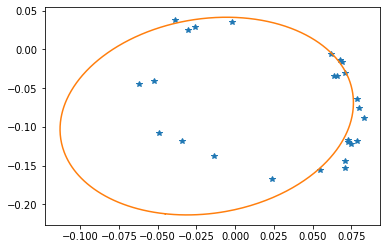

In [586]:
def test(data,a,e,omega,OMEGA,inc):
    t = np.linspace(0,2*np.pi,720)
    X,Y = f(t,a, e, np.radians(omega), np.radians(OMEGA), np.radians(inc))
    plt.plot(data[1], data[2],'*')
    plt.plot(X,Y)
    
test(data_S55, 0.12892857142857145, 0.6833333333333333, 0.20051071730667547, 258.21240559347325, 189.40136325772215)

In [669]:
def improve_fit(data, a, e, omega, OMEGA, inc, name): 
    print("Values for:",name)
    r, theta = r_theta_data(data)
    
    avg_dist_list = []
    for i in range(len(a)):    
        t = np.linspace(0,2*np.pi, 720)
        X,Y = f(t,a[i], e[i], omega[i], OMEGA[i], inc[i])
        dist_list = []
        for j in range(len(data)):
            dist = []
            for n in range(len(X)):
                dist.append( np.sqrt( (X[n] - data[1][j])**2 + (Y[n] - data[2][j])**2 ) )
            dist_list.append(min(dist))
        avg_dist = sum(dist_list)/len(dist_list)
        avg_dist_list.append(avg_dist)
        
    a_new = []
    e_new = []
    omega_new = []
    OMEGA_new = []
    inc_new = []
    
    mini = min(avg_dist_list)
    for i in range(len(avg_dist_list)):
        if avg_dist_list[i] < mini * 1.2:
            a_new.append(a[i])
            e_new.append(e[i])
            omega_new.append(omega[i])
            OMEGA_new.append(OMEGA[i])
            inc_new.append(inc[i])
    
    index = 0
    mini_min = 10

    for i in range(len(a_new)):
        mini = finding_areas(data, a_new[i], e_new[i], omega_new[i], OMEGA_new[i], inc_new[i])[0]
        if mini < mini_min:
            index = i
            mini_min = mini
    print(index, mini_min)
    print(finding_areas(data, a_new[index], e_new[index], omega_new[index], OMEGA_new[index], inc_new[index]))
    print(a_new[index], e_new[index], np.degrees(omega_new[index]), np.degrees(OMEGA_new[index]), np.degrees(inc_new[index]))
    
    a_delta = []
    e_delta = []
    omega_delta = []
    OMEGA_delta = []
    inc_delta = []
    for i in range(len(a_new)):
        mini = finding_areas(data, a_new[i], e_new[i], omega_new[i], OMEGA_new[i], inc_new[i])[0]
        if mini <= mini_min * 1.5:
            a_delta.append(a_new[i]) 
            e_delta.append(e_new[i])
            omega_delta.append(omega_new[i]) 
            OMEGA_delta.append(OMEGA_new[i])
            inc_delta.append(inc_new[i])


    delta_a = max(a_delta)-min(a_delta)
    if delta_a == 0:
        delta_a = 0.01
    delta_e = max(e_delta)-min(e_delta)
    delta_omega = max(omega_delta)-min(omega_delta)
    delta_OMEGA = max(OMEGA_delta)-min(OMEGA_delta)
    delta_inc = max(inc_delta)-min(inc_delta)

    print("\n")
    err_1 = 0
    for i in range(len(data[3])):
        err_1 = err_1 + np.sqrt( data[3][i]**2 + data[4][i]**2 )/r[i]

    err_1 = err_1/len(data[3])
    err_2 = mini_min/finding_areas(data, a_new[index], e_new[index], omega_new[index], OMEGA_new[index], inc_new[index])[-1]

    eps_a = np.sqrt ( (delta_a/(2*a_new[index]))**2 + (err_2)**2 + (err_1)**2 ) * a_new[index]
    eps_e = np.sqrt ( (delta_e/(2*e_new[index]))**2 + (err_2)**2 + (err_1)**2 ) * e_new[index]
    eps_omega = np.sqrt ( (delta_omega/2)**2 + (err_2)**2 + (err_1)**2 ) 
    eps_OMEGA = np.sqrt ( (delta_OMEGA/2)**2 + (err_2)**2 + (err_1)**2 )
    eps_inc = np.sqrt ( (delta_inc/2)**2 + (err_2)**2 + (err_1)**2 ) 

    print("a",eps_a)
    print("e",eps_e)
    print("omega",np.degrees(eps_omega))
    print("OMEGA",np.degrees(eps_OMEGA))
    print("inc",np.degrees(eps_inc))

    eps_P = np.sqrt( (err_2/finding_areas(data, a_new[index], e_new[index], omega_new[index], OMEGA_new[index], inc_new[index])[2])**2 + (eps_a/a_new[index])**2 ) * finding_areas(data, a_new[index], e_new[index], omega_new[index], OMEGA_new[index], inc_new[index])[1]
    print("P",delta_P_S62)
    
    
    if name == "S2":
        D = 8.93
        eps_R = 0.57/8.93
    if name == "S62":
        D = 8.178
        eps_R = 0.13/8.14
    if name == "S55":
        D = 8.19
        eps_R = 0.11/8.19
    if name == "S38":
        D = 8.14
        eps_R = 0.01/8.17

    a = np.tan(np.radians(a_new[index]/60**2))*D*3.08577*10**19
    P = finding_areas(data, a_new[index], e_new[index], omega_new[index], OMEGA_new[index], inc_new[index])[1]*365*24*60**2

    G = 6.67*10**-11

    M = (4*np.pi**2*a**3)/(G*P**2)
    M = M/(1.989*10**30 * 10**6)
    print("Mass:",M,"*10^6 M_sol")
    
    eps_M = M*np.sqrt( (eps_P/finding_areas(data, a_new[index], e_new[index], omega_new[index], OMEGA_new[index], inc_new[index])[1])**2 + (eps_a/a_new[index])**2 + (eps_R)**2)
    print("Usikkerhed på M:", eps_M)
    
improve_fit(data_S55, a_S55_new, e_S55_new, omega_S55_new, OMEGA_S55_new, inc_S55_new, "S55")

Values for: S55
4 1.6983728032466897e-06
(1.6983728032466897e-06, 11.903436750653434, 0.0024579707234191274, 0.0029012008298196544)
0.12035714285714286 0.651264198319279 264.6556301353007 0.0 0.09987314357399449


a 0.01346519164320464
e 0.06775963175719656
omega 132.4615951710759
OMEGA 132.4616025412823
inc 5.967570954553398
P 0.98235325692256
Mass: 6.772105891898068 *10^6 M_sol
Usikkerhed på M: 1.938479355885003


In [666]:
improve_fit(data_S38, a_S38_new, e_S38_new, omega_S38_new, OMEGA_S38_new, inc_S38_new, "S38")

Values for: S38
2 8.059417313064785e-08
(8.059417313064785e-08, 17.04345581940392, 0.005355985877658189, 0.0020049033878056797)
0.14246542873151075 0.844282638305764 76.64934957076983 109.92775966913631 343.19570060102984


a 0.019918361763891782
e 0.055457050560261255
omega 117.654755180877
OMEGA 115.33743336045545
inc 163.1934244733985
P 0.98235325692256
Mass: 5.37882640566894 *10^6 M_sol
Usikkerhed på M: 0.7607177393727897


In [662]:
improve_fit(data_S2, a_S2, e_S2, omega_S2, OMEGA_S2, inc_S2, "S2")

Values for: S2
6 1.0836339042055268e-08
(1.0836339042055268e-08, 15.906586858044442, 0.004217654323192397, 0.001345019934728785)
0.11782799661299123 0.8714285714285714 63.391786160960734 43.06501830780104 39.44226305180918


a 0.0033736192866856813
e 0.04203725087519765
omega 11.245890450414308
OMEGA 12.890639163134495
inc 2.065328807858699
P 0.98235325692256
Mass: 4.612612999624079 *10^6 M_sol
Usikkerhed på M: 0.3487770671832073


In [668]:
improve_fit(data_S62, a_S62_new, e_S62_new, omega_S62_new, OMEGA_S62_new, inc_S62_new, "S62")

Values for: S62
7 5.152908525362034e-05
(5.152908525362034e-05, 6.041888492562789, 0.018023481544296983, 0.0087940486825742)
0.1975 0.9011111111111111 106.03233000848999 305.2835580506442 267.3255961514841


a 0.05070208185382086
e 0.09787928205664434
omega 67.24778779221471
OMEGA 147.39996277710333
inc 44.01542898972031
P 0.98235325692256
Mass: 115.637413930636 *10^6 M_sol
Usikkerhed på M: 56.385379412428485


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


In [634]:
improve_fit(data_S62, [0.08607142857142858], [0.97], [np.radians(183.65160883311106)], [np.radians(306.9304651601979)], [np.radians(302.3934938519093)], "S62")

Values for: S62
0 10
(3.9278166969588514e-09, 10.381992764242401, 0.0020908787657236134)
0.08607142857142858 0.97 183.65160883311106 306.9304651601979 302.3934938519093


a 10.000003643762197
e 10.000002393762575
omega 572.9579322833159
OMEGA 572.9579322833159
inc 572.9579322833159
P 0.98235325692256
Mass: 3.2415899139028137 *10^6 M_sol
Usikkerhed på M: 15512.627171694867
